In [1]:
#Preamble
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import colors
from multiprocessing import Pool
from multiprocessing import cpu_count
import time
import copy
import pickle
import emcee
import corner

In [2]:
def generateEllipse(a,b,centerX,centerY, grid, opacity):
    for x in range(len(grid)):
        for y in range(len(grid[0])):
            if a > 0 and b > 0:
                if ((x-centerX)/a)*((x-centerX)/a) + ((y-centerY)/b)*((y-centerY)/b) <= 1:
                    grid[x][y] = opacity
    
    return grid

In [3]:
def transitSim(a,b,r, speed, times, tref, opacity):
    ab = a/b
    br = b/r
    
    tmin = tref - 1/(2*speed)
    tmax = tref + 1/(2*speed)
    transitTimes = [t for t in times if t >= tmin and t <= tmax]
    flux = [1 for t in times if t < tmin]
    differences = []
    for i in range(1,len(transitTimes)):
        differences.append(transitTimes[i] - transitTimes[i-1])
    
    minDiff = np.min(differences)
    intDiffs = [int(d/minDiff) for d in differences]
    length = np.sum(intDiffs)
    
    
    res = int((2*(b+r))/length)
    if res < 1:
        res = 1
    rnew = int(res*length/(2*(1+br)))
    bnew = int(br*rnew)
    anew = int(ab*bnew)
    newIntDiffs = [res*i for i in intDiffs]
    
    starGrid = np.zeros([2*rnew, 4*bnew+2*rnew+4])
    ellipseGrid = np.zeros([2*rnew, 4*bnew+2*rnew+4])
    starGrid = generateEllipse(rnew,rnew,rnew, 2*bnew+rnew, starGrid,1)
    ellipseGrid = generateEllipse(anew,bnew,rnew,3*bnew+2*rnew + 2,ellipseGrid,opacity)
    planetGrid = np.ones([2*rnew,4*bnew+2*rnew+ 4]) - ellipseGrid
    fluxGrid = np.multiply(starGrid,planetGrid)
    initialFlux = np.sum(fluxGrid)
    
    for i in newIntDiffs:
        for j in range(i):
            planetGrid = np.delete(planetGrid,0,1)
            planetGrid = np.append(planetGrid,np.ones([2*rnew,1]),1)
            
        
        fluxGrid = np.multiply(starGrid,planetGrid)
        percentFlux = np.sum(fluxGrid)/initialFlux
        flux.append(percentFlux)
        
    for t in times:
        if t > tmax:
            flux.append(1)
    
    flux.append(1)
    return flux

In [20]:
def logLikelihood(theta, times, flux, fluxErr):
    """
    Calculates the log likelihood based on the difference between the model and the data
    
    Args:
        theta (list) - parameters of the model
        times (list) - time array of the light curve
        flux (list) - array of flux data points
        fluxErr (list) - array of errors for the flux data points
    
    Returns:
        lnl (float) - log likelihood for the given theta values
    """
    xdim, ydim, velocity, tRef, opacity = theta
    fluxPredicted = transitSim(xdim, ydim,20,velocity,times, tRef,opacity)
    error = [((flux[i] - fluxPredicted[i])**2) /(2*fluxErr[i]**2) for i in range(len(flux))]
    lnl = -np.sum(error)
    return lnl

In [21]:
def logPrior(theta, times):
    """
    Returns flat priors, checking that the given theta values are physically possible
    
    Args:
        theta (list) - parameters of the model
        times (list) time array of the light curve
        
    Returns: 
        lnPrior (float) - fixed log prior value if theta values are allowed, -inf if theta values aren't
    """
    xdim, ydim, velocity, tRef, opacity = theta
    lnPrior = 0
    if times[0] < tRef < times[-1]:##Check to see if center of transit is within the bounds of the light curve
        lnPrior += np.log(1/(times[-1]-times[0]))
    else:
        return -np.inf
    if 0 < xdim < 40 and 0 < ydim < 30 and 0 < velocity < 50 and 0 < opacity < 1: ##Check to see if the shape exists but is not larger than the star
        ##Also check to see that it transits in a consistent direction and not extremely fast
        lnPrior +=  2*np.log(1/100) + np.log(1/50) + np.log(1)
    else:
        return -np.inf
    return lnPrior

In [23]:
def logProbability(theta, times, flux, fluxErr):
    """
    Combines the log likelihood and log prior to get log probability
    
    Args:
        theta (list) - parameters of the model
        times (list)
    """
    startTime = time.time()
    lp = logPrior(theta, times)
    if not np.isfinite(lp):
        return -np.inf
    ll = logLikelihood(theta, times, flux, fluxErr)
    endTime = time.time()
    print(endTime - startTime)
    return (lp + ll)

In [7]:
def getData(filename): 
    """
    Reads the necessary data from the elanor pipeline TESS lightcurve pickle files
    
    Args:
        filename (string) - name of the pickle file excluding the .pkl extension
        
    Returns:
        times (list) - list of times of observations in moditied julian day
        flux (list) - list of normalized flux values
        err (list) - list of error for the flux values
    """
    fp = open("./"+filename+".pkl","rb") 
    data = pickle.load(fp)##Unpickles the file
    fp.close()
    
    q = data[11]==0 ##Get the locations of high quality data
    times = data[6][q]##Take only high quality data
    flux = data[9][q]
    maxFlux = np.median(flux)
    flux /= maxFlux ##Normalize flux
    err = np.ones_like(flux)*np.nanstd(np.diff(flux))##Calculate error
    err /= np.sqrt(2)
    return times, flux, err

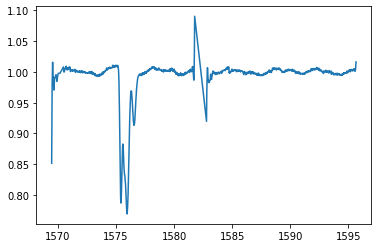

In [7]:
times, flux, _ = getData("lcs/tesslc_400799224")
fig = plt.subplot()
fig.plot(times, flux)
plt.show()

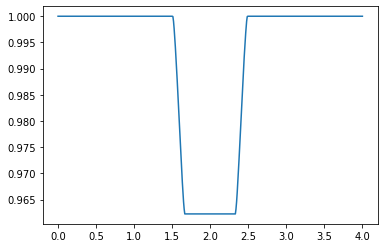

In [8]:
times = np.linspace(0,4,1000)
flux = transitSim(10,10,50,1,times,2,1)
fluxErr = 0.05*np.ones(1000)
fig = plt.subplot()
fig.plot(times, flux)
plt.show()

In [24]:
pos = [10,10,2,2,1] * np.ones([12,5]) + np.random.random([12,5]) - 0.5
nwalkers, ndim = pos.shape

with Pool() as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, logProbability, args = (times, flux, fluxErr))
    sampler.run_mcmc(pos,500, progress = True)

0.021196603775024414
0.06096339225769043
0.024316072463989258
0.030527114868164062
0.01919698715209961
0.05780935287475586
0.031191110610961914


  0%|                                                                                                    | 0/500 [00:00<?, ?it/s]

0.019364595413208008
0.042102813720703125
0.027146577835083008


  0%|▏                                                                                           | 1/500 [00:00<03:17,  2.53it/s]

0.2102811336517334
0.02474069595336914
0.033264875411987305
0.011376380920410156
0.022889375686645508
0.02017498016357422
0.014809370040893555
0.02978682518005371
0.021668195724487305


  0%|▎                                                                                           | 2/500 [00:00<02:35,  3.19it/s]

0.018857717514038086
0.07182097434997559
0.02507495880126953
0.026421785354614258
0.019908428192138672
0.013947486877441406
0.024691343307495117


  1%|▌                                                                                           | 3/500 [00:00<02:18,  3.59it/s]

0.04912114143371582
0.0875997543334961
0.024231672286987305
0.014180421829223633
0.018728017807006836
0.01597142219543457
0.03187417984008789
0.022311687469482422
0.045922040939331055
0.020980358123779297
0.061243295669555664
0.025101900100708008
0.0341184139251709


  1%|▋                                                                                           | 4/500 [00:01<02:19,  3.55it/s]

0.021526336669921875
0.023904800415039062
0.025841712951660156
0.022054433822631836
0.03654217720031738
0.02227163314819336
0.02001667022705078
0.027701616287231445


  1%|▉                                                                                           | 5/500 [00:01<02:13,  3.70it/s]

0.026764631271362305
0.0184323787689209
0.02080225944519043
0.02787017822265625
0.018589019775390625
0.07567715644836426
0.0267789363861084


  1%|█                                                                                           | 6/500 [00:01<02:25,  3.39it/s]

0.024938344955444336
0.014483451843261719
0.04129314422607422
0.01978302001953125
0.04726576805114746
0.01851630210876465
0.021648168563842773
0.018437623977661133
0.03691911697387695
0.011338949203491211
0.017975330352783203
0.02099776268005371
0.04319143295288086
0.014708995819091797
0.046472787857055664
0.030233144760131836


  1%|█▎                                                                                          | 7/500 [00:02<02:32,  3.23it/s]

0.07439136505126953
0.018953800201416016
0.023983001708984375
0.03193163871765137
0.02886199951171875
0.0186159610748291
0.017209529876708984
0.0398104190826416


  2%|█▍                                                                                          | 8/500 [00:02<02:16,  3.60it/s]

0.02011394500732422
0.02190256118774414
0.015104532241821289
0.01283717155456543
0.026810646057128906
0.028858184814453125
0.021680831909179688
0.02759838104248047
0.024794816970825195


  2%|█▋                                                                                          | 9/500 [00:02<02:07,  3.85it/s]

0.02418065071105957
0.03276467323303223
0.023099184036254883
0.02162623405456543
0.025800228118896484
0.01994943618774414
0.0196230411529541
0.01582169532775879


  2%|█▊                                                                                         | 10/500 [00:02<02:01,  4.05it/s]

0.05716276168823242
0.02901768684387207
0.03235793113708496
0.029183387756347656
0.013857603073120117
0.021764755249023438
0.01971125602722168
0.025678157806396484
0.01745438575744629
0.0051686763763427734

  2%|██                                                                                         | 11/500 [00:03<02:01,  4.01it/s]


0.020691394805908203
0.025435209274291992
0.03409314155578613
0.025666236877441406
0.03474831581115723
0.0405731201171875


  2%|██▏                                                                                        | 12/500 [00:03<02:00,  4.06it/s]

0.01909947395324707
0.016084909439086914
0.017268657684326172
0.006018638610839844
0.02740764617919922
0.04814028739929199
0.017429113388061523
0.011493206024169922
0.014786720275878906
0.016274213790893555


  3%|██▎                                                                                        | 13/500 [00:03<01:52,  4.32it/s]

0.025181055068969727
0.06678938865661621
0.021514177322387695
0.017122507095336914
0.027539968490600586
0.017524242401123047


  3%|██▌                                                                                        | 14/500 [00:03<02:01,  4.00it/s]

0.06455421447753906
0.021884679794311523
0.007123708724975586
0.018784761428833008
0.11183547973632812
0.018822431564331055
0.02201223373413086
0.022191286087036133
0.05553555488586426
0.017203092575073242
0.030786991119384766
0.01999354362487793
0.06481623649597168
0.012476682662963867
0.0255887508392334


  3%|██▋                                                                                        | 15/500 [00:04<02:37,  3.08it/s]

0.19382119178771973
0.02633833885192871
0.022629737854003906
0.1154642105102539
0.014782905578613281


  3%|██▉                                                                                        | 16/500 [00:04<02:37,  3.07it/s]

0.024471759796142578
0.017263174057006836
0.059528350830078125
0.01806640625
0.02665114402770996
0.021404266357421875
0.020952701568603516
0.022606372833251953


  3%|███                                                                                        | 17/500 [00:04<02:20,  3.43it/s]

0.02898263931274414
0.01734757423400879
0.013969182968139648
0.02001023292541504
0.017247438430786133
0.05301523208618164
0.013955354690551758
0.02105998992919922
0.014086723327636719
0.011402130126953125


  4%|███▎                                                                                       | 18/500 [00:05<02:19,  3.47it/s]

0.04399919509887695
0.017420530319213867
0.04933571815490723
0.023646116256713867
0.0332639217376709
0.0372161865234375
0.02300119400024414
0.02341008186340332
0.06154060363769531
0.017429590225219727


  4%|███▍                                                                                       | 19/500 [00:05<02:36,  3.07it/s]

0.17928695678710938
0.024428606033325195
0.01742696762084961
0.016547679901123047
0.027098894119262695
0.027901411056518555
0.011914491653442383
0.02130579948425293
0.011511802673339844
0.027957439422607422
0.02107381820678711
0.0177462100982666
0.01549673080444336
0.0738978385925293
0.015833616256713867
0.025884151458740234


  4%|███▋                                                                                       | 20/500 [00:05<02:33,  3.13it/s]

0.06578540802001953
0.007779121398925781
0.021341562271118164
0.021965503692626953
0.0686643123626709
0.03202462196350098


  4%|███▊                                                                                       | 21/500 [00:06<02:31,  3.17it/s]

0.06321835517883301
0.013227701187133789
0.02152276039123535
0.02830958366394043
0.022459983825683594
0.024438858032226562
0.03275561332702637
0.02288532257080078


  4%|████                                                                                       | 22/500 [00:12<17:26,  2.19s/it]

6.277637243270874
0.032378196716308594
0.017823457717895508
0.02631545066833496
0.03140974044799805
0.013741731643676758
0.04000282287597656
0.03183722496032715
0.022893667221069336
0.03571629524230957
0.018421411514282227
0.019571542739868164
0.018138885498046875
0.023491859436035156
0.020859956741333008


  5%|████▏                                                                                      | 23/500 [00:12<12:52,  1.62s/it]

0.12581443786621094
0.008722782135009766
0.019008636474609375
0.03551983833312988
0.027168989181518555
0.03894448280334473
0.05306529998779297


  5%|████▎                                                                                      | 24/500 [00:13<09:39,  1.22s/it]

0.016230344772338867
0.06054973602294922
0.011677265167236328
0.020354509353637695
0.053505659103393555
0.017470359802246094
0.018210172653198242
0.03780817985534668
0.10387301445007324
0.006690263748168945
0.017130613327026367
0.013801336288452148
0.044022321701049805


  5%|████▌                                                                                      | 25/500 [00:13<07:35,  1.04it/s]

0.018126249313354492
0.019788742065429688
0.025827884674072266
0.018733739852905273
0.009888887405395508


  5%|████▋                                                                                      | 26/500 [00:20<21:02,  2.66s/it]

6.418182849884033
0.011948108673095703
0.06484580039978027
0.012300491333007812
0.03246283531188965
0.0207517147064209
0.024822473526000977
0.03908085823059082


  5%|████▉                                                                                      | 27/500 [00:23<22:55,  2.91s/it]

3.254608631134033
0.01866769790649414
0.045265913009643555
0.004166841506958008
0.026050806045532227
0.014846563339233398
0.014605283737182617
0.032971858978271484
0.15607190132141113
0.020825862884521484
0.008882999420166016
0.02535390853881836
0.013128519058227539
0.07067322731018066
0.042386531829833984
0.0261991024017334
0.03365325927734375


  6%|█████                                                                                      | 28/500 [00:25<20:46,  2.64s/it]

1.5951929092407227
0.01906585693359375
0.02423095703125
0.25954198837280273
0.028359174728393555
0.10915732383728027
0.008815765380859375
0.013457298278808594
0.017281770706176758


  6%|█████▎                                                                                     | 29/500 [00:26<15:53,  2.02s/it]

0.09283304214477539
0.023057222366333008
0.021132469177246094
0.021967411041259766
0.025462627410888672
0.36528491973876953
0.02691054344177246
0.058746337890625
0.04084420204162598


  6%|█████▍                                                                                     | 30/500 [00:27<13:29,  1.72s/it]

0.327251672744751
0.10674786567687988
0.014623641967773438
0.021056175231933594
3.303755760192871
0.022029876708984375
0.04703402519226074


  6%|█████▋                                                                                     | 31/500 [00:31<18:41,  2.39s/it]

0.36842966079711914
0.03181624412536621
0.024019479751586914
0.04696059226989746
0.06443595886230469
0.019995689392089844
0.05452132225036621
0.008785247802734375
0.02433633804321289
0.039937496185302734
0.07526206970214844
0.019149303436279297


  6%|█████▊                                                                                     | 32/500 [00:31<14:03,  1.80s/it]

0.03323531150817871
0.1524813175201416
0.012024641036987305
0.025840282440185547
0.023828744888305664
0.02747488021850586
0.5824177265167236
0.027201175689697266
0.014577865600585938


  7%|██████                                                                                     | 33/500 [00:32<12:25,  1.60s/it]

0.237060546875
0.0137939453125
0.09083008766174316
0.0680696964263916
0.01799917221069336
0.035482168197631836
0.07284808158874512
0.04649043083190918
0.9815528392791748
0.005684852600097656
0.025634288787841797
0.18193697929382324
0.19382715225219727


  7%|██████▏                                                                                    | 34/500 [00:34<12:23,  1.60s/it]

0.02479839324951172
0.04506731033325195
0.062293052673339844
0.0045166015625
0.031803131103515625
0.26042866706848145
0.05431032180786133
0.02303147315979004
0.06776189804077148


  7%|██████▎                                                                                    | 35/500 [00:35<10:08,  1.31s/it]

0.07012605667114258
0.016083240509033203
2.112720251083374
0.005671024322509766
0.03272199630737305
0.09487557411193848
0.04716920852661133
0.018424272537231445

  7%|██████▌                                                                                    | 36/500 [00:37<12:54,  1.67s/it]


0.03889012336730957
0.029126882553100586
0.03766942024230957
0.08001995086669922
0.03803563117980957
0.045675039291381836
0.035056352615356445
0.049048423767089844
0.039810895919799805
0.013687610626220703
0.04210400581359863


  7%|██████▋                                                                                    | 37/500 [00:38<10:26,  1.35s/it]

0.2241222858428955
0.03937077522277832
0.0867617130279541
0.03434348106384277
0.04232144355773926
0.10994148254394531
0.041571617126464844
0.010273456573486328
0.03940844535827637
0.138031005859375


  8%|██████▉                                                                                    | 38/500 [00:38<08:52,  1.15s/it]

0.10093998908996582
0.145188570022583
0.016706228256225586
0.03972458839416504
0.37662506103515625
0.04576516151428223
0.02118659019470215
0.006726503372192383
0.028246164321899414
0.11436629295349121


  8%|███████                                                                                    | 39/500 [00:42<15:29,  2.02s/it]

3.270791530609131
0.10216474533081055
0.015933752059936523
0.09934163093566895
0.05371212959289551
0.07757782936096191
0.03477287292480469
0.038895368576049805
0.06157875061035156
0.007365226745605469
0.036583662033081055
0.0834360122680664


  8%|███████▎                                                                                   | 40/500 [00:43<12:04,  1.57s/it]

0.04584670066833496
0.04744911193847656
0.21469521522521973
0.036644935607910156
0.04080510139465332
0.04419565200805664
0.06348991394042969
0.018239259719848633
0.04506731033325195
0.027175188064575195
0.10372710227966309


  8%|███████▍                                                                                   | 41/500 [00:44<10:00,  1.31s/it]

0.03576231002807617
0.03590106964111328
0.0990445613861084
0.05639290809631348
0.03550243377685547


  8%|███████▋                                                                                   | 42/500 [00:44<08:28,  1.11s/it]

0.2390577793121338
0.04911375045776367
0.025968074798583984
0.03681182861328125
0.03411078453063965
0.029432296752929688
1.071537971496582
0.025896549224853516
0.047978878021240234
0.06468534469604492
0.051978111267089844
0.03511667251586914
0.047821998596191406
0.05542922019958496


  9%|███████▊                                                                                   | 43/500 [00:46<09:41,  1.27s/it]

0.21678638458251953
0.029657840728759766
0.030550718307495117
0.0327608585357666
0.05789589881896973
0.05905318260192871
0.05338931083679199
0.0271453857421875
0.034552812576293945
0.03731846809387207


  9%|████████                                                                                   | 44/500 [00:47<08:49,  1.16s/it]

0.4069669246673584
0.017518997192382812
0.04688382148742676
0.08846235275268555
0.027252674102783203
0.8253164291381836
0.02097916603088379
0.04859423637390137
0.05677080154418945
0.02561330795288086
0.009905815124511719
0.006621599197387695
0.1004478931427002
0.1636824607849121


  9%|████████▏                                                                                  | 45/500 [00:48<09:33,  1.26s/it]

0.16100239753723145
0.04284024238586426
0.03104114532470703
0.045345306396484375
0.008222579956054688
0.04792952537536621
0.10141253471374512
0.020980119705200195
0.03275322914123535
0.012828350067138672
0.12024521827697754


  9%|████████▎                                                                                  | 46/500 [00:49<07:58,  1.05s/it]

0.1184852123260498
0.025202512741088867
0.03632664680480957
0.04445838928222656
0.022305965423583984
0.047354936599731445
0.03168463706970215
0.5705099105834961
0.24605107307434082
0.0065021514892578125
0.05355072021484375
0.09217691421508789
0.04110431671142578


  9%|████████▌                                                                                  | 47/500 [00:50<08:21,  1.11s/it]

0.028073549270629883
0.037541866302490234
0.021674633026123047
0.05716872215270996
0.9822580814361572
0.06400823593139648


 10%|████████▋                                                                                  | 48/500 [00:52<10:44,  1.42s/it]

0.8571338653564453
0.03667712211608887
0.05729341506958008
0.03715777397155762
0.011498689651489258
0.03419160842895508
0.05057191848754883
0.03746485710144043
0.02892470359802246
0.06471061706542969
0.03258180618286133
0.03142976760864258


 10%|████████▉                                                                                  | 49/500 [00:53<08:38,  1.15s/it]

0.11626148223876953
0.07640624046325684
0.02552032470703125
0.08129453659057617
0.048058509826660156
0.2783854007720947
0.09467244148254395
0.03148508071899414
0.02309131622314453
0.014797210693359375
0.031352996826171875


 10%|█████████                                                                                  | 50/500 [00:54<07:39,  1.02s/it]

0.047415971755981445
0.06517529487609863
0.03415393829345703
0.03205728530883789
0.05424189567565918
0.04885411262512207
0.07415556907653809
0.04623246192932129
0.04347348213195801


 10%|█████████▎                                                                                 | 51/500 [00:54<06:53,  1.09it/s]

0.1876058578491211
0.006648540496826172
0.062024593353271484
0.0602114200592041
0.029571533203125
0.49428415298461914
0.11662793159484863
0.31748223304748535
0.07527899742126465
0.029678821563720703
0.03936052322387695
0.046018123626708984


 10%|█████████▍                                                                                 | 52/500 [00:55<07:37,  1.02s/it]

0.0496828556060791
0.08422684669494629
0.06343317031860352
0.022937536239624023
0.10430455207824707
0.03481578826904297
0.1309986114501953
0.05716705322265625
0.05732893943786621
0.05437517166137695


 11%|█████████▋                                                                                 | 53/500 [01:02<20:19,  2.73s/it]

6.151406764984131
0.02633523941040039
0.04754900932312012
0.14354705810546875
0.011377811431884766
0.06372618675231934
6.149671316146851
0.03136444091796875
0.029216289520263672
0.09907221794128418
0.05089068412780762


 11%|█████████▊                                                                                 | 54/500 [01:09<30:09,  4.06s/it]

0.48545408248901367
0.03666543960571289
0.010375022888183594
0.08586931228637695
0.04907870292663574
0.10509467124938965
0.030440330505371094
0.03034830093383789
0.04497861862182617


 11%|██████████                                                                                 | 55/500 [01:15<33:50,  4.56s/it]

5.214651584625244
0.07369399070739746
0.09370660781860352
0.04880070686340332
0.34519052505493164
0.005181312561035156
0.10109138488769531
0.06841826438903809
0.02878427505493164
0.02901911735534668
0.07232952117919922
0.05723738670349121


 11%|██████████▏                                                                                | 56/500 [01:16<25:33,  3.45s/it]

0.0592496395111084
0.04035377502441406
0.21119093894958496
0.13959074020385742
0.4802677631378174
0.040376901626586914
0.16781139373779297
0.041361093521118164


 11%|██████████▎                                                                                | 57/500 [01:18<23:10,  3.14s/it]

1.1309573650360107
0.01763463020324707
0.026652097702026367
0.12201976776123047
0.020650148391723633
0.13058948516845703
0.017565250396728516
0.05629730224609375
0.05336499214172363
0.02050185203552246
0.1513221263885498
0.1437985897064209
0.01385354995727539
0.05863690376281738
0.049391746520996094


 12%|██████████▌                                                                                | 58/500 [01:19<18:35,  2.52s/it]

0.3883481025695801
0.04345083236694336
0.1631486415863037
0.061911582946777344
0.03230714797973633
0.0751349925994873
0.11239933967590332
0.18901944160461426


 12%|██████████▋                                                                                | 59/500 [01:20<14:39,  1.99s/it]

0.045891761779785156
0.027132749557495117
0.05142974853515625
0.022931814193725586
0.0399017333984375
0.21586394309997559
0.048659563064575195
0.02400970458984375
0.16583895683288574
0.1379406452178955


 12%|██████████▉                                                                                | 60/500 [01:22<13:15,  1.81s/it]

0.524263858795166
0.00998067855834961
0.04773402214050293
0.07980918884277344
0.3392066955566406
0.0334017276763916
0.034305572509765625
0.05662131309509277
6.45533561706543
0.05264425277709961
0.15087366104125977
0.0662381649017334


 12%|███████████                                                                                | 61/500 [01:29<25:40,  3.51s/it]

0.17398905754089355
0.06894111633300781
0.04098010063171387
0.0407106876373291
0.02568221092224121
0.18496227264404297
0.05754423141479492
0.04651618003845215
0.11053156852722168
0.11526274681091309
0.06643891334533691


 12%|███████████▎                                                                               | 62/500 [01:30<19:38,  2.69s/it]

0.08092665672302246
0.04088616371154785
0.4921731948852539
0.017815113067626953
0.05103015899658203
0.21106791496276855
0.027200698852539062
0.06531667709350586
0.016104936599731445


 13%|███████████▍                                                                               | 63/500 [01:31<16:15,  2.23s/it]

0.12068724632263184
0.043877601623535156
0.07037782669067383
0.042514801025390625
0.07047486305236816
0.005980014801025391
0.1578989028930664
0.04164743423461914
0.05613541603088379
0.4502701759338379
0.32280850410461426
0.10561776161193848
0.06942081451416016


 13%|███████████▋                                                                               | 64/500 [01:33<14:55,  2.05s/it]

0.35196852684020996
0.028535127639770508
0.14778399467468262
0.12793445587158203
0.02113175392150879
0.26550865173339844
0.08947062492370605
1.1155040264129639
0.0456852912902832


 13%|███████████▊                                                                               | 65/500 [01:35<15:18,  2.11s/it]

0.2607381343841553
0.07739734649658203
0.05525636672973633
0.1372849941253662
0.760695219039917
0.017684459686279297
0.244551420211792
0.055181264877319336
0.012856245040893555
0.03830695152282715
0.05825495719909668


 13%|████████████                                                                               | 66/500 [01:36<14:02,  1.94s/it]

0.0650784969329834
0.07701754570007324
0.0743253231048584
0.013921022415161133
0.02069878578186035
0.07544612884521484
0.25385189056396484
0.07699847221374512
0.09235692024230957
0.1960158348083496
0.4895741939544678


 13%|████████████▏                                                                              | 67/500 [01:38<13:20,  1.85s/it]

0.27326035499572754
0.06305837631225586
0.06891918182373047
0.017818450927734375
0.043787240982055664
0.07318925857543945
0.07848763465881348
0.06845331192016602
0.07026362419128418
0.8351266384124756
0.1573781967163086
0.06252002716064453
0.15040349960327148


 14%|████████████▍                                                                              | 68/500 [01:40<12:56,  1.80s/it]

0.11543488502502441
0.15276694297790527
0.005724906921386719
0.14965033531188965
0.06868648529052734
0.07502579689025879
0.3529946804046631
0.05652499198913574
0.34791135787963867
0.0773625373840332
0.11538004875183105


 14%|████████████▌                                                                              | 69/500 [01:41<12:17,  1.71s/it]

0.10031867027282715
0.049497127532958984
0.20143508911132812
0.09759235382080078
0.091522216796875
0.0648488998413086
2.617002248764038
0.11199188232421875
0.06500482559204102


 14%|████████████▋                                                                              | 70/500 [01:45<15:54,  2.22s/it]

0.09807038307189941
0.1643991470336914
0.008562803268432617
0.03197526931762695
0.05437111854553223
0.7023818492889404
0.0933692455291748
0.13722515106201172
0.1396031379699707
0.0341489315032959


 14%|████████████▉                                                                              | 71/500 [01:46<14:26,  2.02s/it]

0.11059856414794922
0.07322216033935547
0.21584486961364746
0.11532473564147949
0.08941078186035156
0.11886024475097656
0.019731521606445312
0.03410696983337402
0.05269217491149902
0.09432101249694824


 14%|█████████████                                                                              | 72/500 [01:47<12:29,  1.75s/it]

0.29834747314453125
0.0778660774230957
0.006434202194213867
0.04855751991271973
0.08209967613220215
0.1987011432647705
0.13808345794677734
0.04537057876586914
0.3286705017089844
0.1528167724609375
0.022972583770751953


 15%|█████████████▎                                                                             | 73/500 [01:48<10:59,  1.54s/it]

0.03138422966003418
0.35288190841674805
0.09014511108398438
0.17644476890563965
0.10339951515197754
0.1407933235168457
0.21123194694519043


 15%|█████████████▍                                                                             | 74/500 [01:50<11:38,  1.64s/it]

0.6029460430145264
0.011550188064575195
0.05382990837097168
0.11242818832397461
0.008277177810668945
0.07898139953613281
0.07548165321350098
0.11769485473632812
0.10946035385131836
0.990835428237915
0.13966083526611328
0.02157902717590332
0.953174352645874
0.13509464263916016


 15%|█████████████▋                                                                             | 75/500 [01:53<13:53,  1.96s/it]

0.07154965400695801
0.2050333023071289
0.23338866233825684
0.030719995498657227
0.00648951530456543
0.07207226753234863
0.12190365791320801
0.05966830253601074
6.264265298843384
0.4442875385284424
0.22870683670043945
0.13668012619018555


 15%|█████████████▊                                                                             | 76/500 [02:01<26:28,  3.75s/it]

0.10523056983947754
0.4676539897918701
0.017761945724487305
0.11827516555786133
0.4087522029876709
0.216355562210083
0.18825316429138184
0.030849933624267578
0.1448078155517578
0.06351590156555176


 15%|██████████████                                                                             | 77/500 [02:04<24:07,  3.42s/it]

0.9062986373901367
0.09386897087097168
0.13947844505310059
0.21249699592590332
0.27278614044189453
0.022151470184326172
0.22818875312805176
0.21157264709472656
1.6552798748016357
0.1405947208404541
0.10785555839538574
0.11788773536682129


 16%|██████████████▏                                                                            | 78/500 [02:07<24:49,  3.53s/it]

0.663748025894165
0.18222713470458984
2.38842511177063
0.24768853187561035
0.0741419792175293
0.9711534976959229
0.3061408996582031
0.14017796516418457
0.10386824607849121


 16%|██████████████▍                                                                            | 79/500 [02:12<27:05,  3.86s/it]

0.21705389022827148
0.8488814830780029
0.03101038932800293
0.13079833984375
0.04427218437194824
0.25443005561828613
0.1834414005279541
0.40703392028808594
0.08637356758117676
0.06276321411132812


 16%|██████████████▌                                                                            | 80/500 [02:14<23:30,  3.36s/it]

0.12615633010864258
0.16661453247070312
0.018299102783203125
0.14700007438659668
0.08877062797546387
0.15182733535766602
0.13895297050476074
0.18831086158752441


 16%|██████████████▋                                                                            | 81/500 [02:17<23:24,  3.35s/it]

2.4292614459991455
0.18364644050598145
0.14689230918884277
0.040999412536621094
0.14940810203552246
0.30477356910705566
0.1440291404724121
0.2584822177886963


 16%|██████████████▉                                                                            | 82/500 [02:19<19:39,  2.82s/it]

0.21397852897644043
0.1350715160369873
0.4280273914337158
0.12860703468322754
0.0111846923828125
0.14544224739074707
0.13814687728881836
0.0705709457397461
0.11342620849609375
0.23327207565307617
0.1544046401977539


 17%|███████████████                                                                            | 83/500 [02:21<17:13,  2.48s/it]

0.18922042846679688
0.05664253234863281
0.018522262573242188
0.14612364768981934
0.13778209686279297
1.9371469020843506
0.1254713535308838
0.20093846321105957
0.39589881896972656
0.0337827205657959
0.14990568161010742


 17%|███████████████▎                                                                           | 84/500 [02:24<19:18,  2.78s/it]

0.1512012481689453
0.19587039947509766
0.0754234790802002
0.17364501953125
0.15172243118286133
0.1988532543182373
0.08533310890197754
0.400862455368042
6.290807008743286
0.12180924415588379


 17%|███████████████▍                                                                           | 85/500 [02:32<29:59,  4.34s/it]

0.3472762107849121
0.10743832588195801
0.31159520149230957
0.0243070125579834
0.12854743003845215
0.042923688888549805
0.15067744255065918
0.12057209014892578
0.02141714096069336
0.1926870346069336
0.1339273452758789
0.27066683769226074
0.1448497772216797


 17%|███████████████▋                                                                           | 86/500 [02:34<24:25,  3.54s/it]

0.1279137134552002
0.15831947326660156
0.4354281425476074
0.13646936416625977
0.19898080825805664
0.07716631889343262
0.36796116828918457
0.2661404609680176
0.03943920135498047
0.15588045120239258


 17%|███████████████▊                                                                           | 87/500 [02:36<21:06,  3.07s/it]

0.12365365028381348
0.12842702865600586
0.05784249305725098
0.24116015434265137
0.09785795211791992
0.01666092872619629
0.16568446159362793
0.27709174156188965
0.13308238983154297


 18%|████████████████                                                                           | 88/500 [02:37<17:25,  2.54s/it]

0.12117218971252441
0.057623863220214844
0.7953817844390869
0.12534713745117188
6.297005891799927
0.11825799942016602
0.2370443344116211
0.11698317527770996
0.0759127140045166
0.2709805965423584
0.025993824005126953
0.03238081932067871
0.15520620346069336


 18%|████████████████▏                                                                          | 89/500 [02:46<29:37,  4.32s/it]

0.23343873023986816
0.24866199493408203
0.006582975387573242
0.11922311782836914
0.151566743850708
0.19964241981506348
0.12688207626342773
0.13747835159301758
0.31304001808166504
0.03501081466674805
0.1507425308227539


 18%|████████████████▍                                                                          | 90/500 [02:47<24:16,  3.55s/it]

0.2546200752258301
0.13231492042541504
1.3769950866699219
0.08695054054260254
0.1209259033203125
0.08379125595092773
0.1237492561340332
0.21750283241271973
0.024208545684814453
0.012409210205078125
0.17200136184692383
0.1423327922821045


 18%|████████████████▌                                                                          | 91/500 [02:50<22:29,  3.30s/it]

0.21026825904846191
0.21202421188354492
0.36132264137268066
0.0053310394287109375
0.14448118209838867
0.0830996036529541
0.10002374649047852
0.038291215896606445
0.1029365062713623
0.17856311798095703


 18%|████████████████▋                                                                          | 92/500 [02:51<18:28,  2.72s/it]

0.12429976463317871
0.131974458694458
0.05069470405578613
0.08855915069580078
0.046704769134521484
0.11258339881896973
0.21329140663146973
0.20916271209716797
0.9071438312530518
0.005277156829833984
0.1137092113494873


 19%|████████████████▉                                                                          | 93/500 [02:54<17:17,  2.55s/it]

0.14629626274108887
0.12805390357971191
0.13906455039978027
0.26366186141967773
0.1752326488494873
0.13198471069335938
0.20743155479431152
0.11783957481384277
0.11754918098449707
0.20255208015441895
0.13535213470458984


 19%|█████████████████                                                                          | 94/500 [02:55<15:18,  2.26s/it]

0.0907585620880127
0.10836362838745117
0.14700555801391602
0.09699225425720215
0.20843005180358887
5.602571725845337
0.024506092071533203
0.19202184677124023
0.12752914428710938


 19%|█████████████████▎                                                                         | 95/500 [03:02<24:15,  3.59s/it]

0.18994545936584473
0.07649612426757812
0.08624815940856934
2.0320160388946533
0.31015491485595703
0.2615041732788086
0.020310401916503906
0.052629709243774414
0.4651205539703369


 19%|█████████████████▍                                                                         | 96/500 [03:06<24:34,  3.65s/it]

0.336423397064209
0.12973856925964355
0.3136107921600342
0.26212000846862793
0.09907269477844238
0.3040165901184082
0.2109208106994629
0.12912654876708984
0.032053232192993164


 19%|█████████████████▋                                                                         | 97/500 [03:07<20:25,  3.04s/it]

0.13816499710083008
0.12975406646728516
0.2108619213104248
0.008164167404174805
0.11400246620178223
0.22089624404907227
0.16145110130310059
0.20151519775390625
0.10161185264587402
0.1287987232208252


 20%|█████████████████▊                                                                         | 98/500 [03:09<17:12,  2.57s/it]

0.242828369140625
0.06896662712097168
0.023856401443481445
0.3326425552368164
0.12209248542785645
0.06355500221252441
0.11465573310852051
0.21055126190185547
0.20645475387573242
0.13724827766418457
0.16518950462341309
0.13369488716125488


 20%|██████████████████                                                                         | 99/500 [03:10<15:19,  2.29s/it]

0.1324770450592041
0.03481268882751465
0.39296698570251465
0.13168573379516602
0.13136816024780273
0.19359827041625977
0.33686161041259766
0.10555005073547363
0.12800097465515137
0.1067347526550293


 20%|██████████████████                                                                        | 100/500 [03:12<14:13,  2.13s/it]

0.19226503372192383
0.017683029174804688
0.11220169067382812
0.10993528366088867
0.18795204162597656
0.16154003143310547
0.5008747577667236
0.12851548194885254
0.13661479949951172


 20%|██████████████████▏                                                                       | 101/500 [03:14<13:09,  1.98s/it]

0.2539083957672119
0.045639753341674805
0.7096869945526123
0.019854307174682617
0.16699695587158203
0.39826369285583496
0.20896267890930176
0.10249567031860352
0.08779263496398926
1.776468276977539
0.12312102317810059


 20%|██████████████████▎                                                                       | 102/500 [03:18<16:46,  2.53s/it]

0.16670751571655273
0.5682430267333984
0.12387824058532715
0.1334092617034912
0.22128868103027344
0.1705617904663086


 21%|██████████████████▌                                                                       | 103/500 [03:19<14:50,  2.24s/it]

0.15476393699645996
0.19867753982543945
0.061141252517700195
0.07816553115844727
0.09197139739990234
0.16786837577819824
0.1316378116607666
0.19104480743408203
0.21134233474731445
0.11630606651306152


 21%|██████████████████▋                                                                       | 104/500 [03:21<13:28,  2.04s/it]

0.3411886692047119
0.16941380500793457
0.03219866752624512
0.006714344024658203
0.08979916572570801
0.1256091594696045
0.15359950065612793
0.08511829376220703
0.15350937843322754
0.22089433670043945
0.09034609794616699
0.06396818161010742


 21%|██████████████████▉                                                                       | 105/500 [03:22<12:15,  1.86s/it]

0.21762871742248535
0.1978316307067871
0.12603378295898438
0.15768766403198242
0.42362117767333984
0.021716833114624023
0.1184542179107666
0.21283912658691406
0.1162259578704834
2.7466835975646973
0.15143275260925293


 21%|███████████████████                                                                       | 106/500 [03:26<16:56,  2.58s/it]

0.13559365272521973
0.03302645683288574
0.14441370964050293
0.05110669136047363
0.08801126480102539
0.14754629135131836
0.04688906669616699
0.0065724849700927734
0.13072681427001953
0.13674187660217285
0.1332693099975586


 21%|███████████████████▎                                                                      | 107/500 [03:28<13:58,  2.13s/it]

0.19988369941711426
0.3058938980102539
0.10563945770263672
0.011751413345336914
0.15337824821472168
0.22000575065612793
0.14603662490844727
0.15059828758239746
0.07402801513671875
0.16314220428466797
0.15418696403503418


 22%|███████████████████▍                                                                      | 108/500 [03:29<12:47,  1.96s/it]

0.05904388427734375
0.22525835037231445
0.02443838119506836
0.1507706642150879
0.13990235328674316
0.9945094585418701
0.16352510452270508
0.1376957893371582
0.09233999252319336
0.12875056266784668


 22%|███████████████████▌                                                                      | 109/500 [03:31<13:39,  2.10s/it]

0.35680246353149414
0.11249160766601562
0.11030173301696777
0.1506786346435547
0.12785673141479492
0.3368842601776123
0.16213583946228027
0.15175843238830566


 22%|███████████████████▊                                                                      | 110/500 [03:33<12:36,  1.94s/it]

0.27368688583374023
0.137892484664917
0.3943331241607666
0.07688045501708984
0.20687103271484375
0.12677884101867676
0.5353856086730957
0.04070734977722168
0.15467000007629395
0.020740509033203125
0.15791845321655273


 22%|███████████████████▉                                                                      | 111/500 [03:35<12:55,  1.99s/it]

0.400052547454834
0.010930061340332031
1.2323362827301025
0.0255434513092041
0.246537446975708
0.18878841400146484
0.18152689933776855
0.15440583229064941
0.02619194984436035
0.0695493221282959
0.2147688865661621


 22%|████████████████████▏                                                                     | 112/500 [03:39<15:43,  2.43s/it]

0.9407010078430176
0.1570878028869629
0.24144339561462402
0.17539572715759277
0.22858309745788574
0.34659528732299805
1.1040034294128418
0.12781858444213867


 23%|████████████████████▎                                                                     | 113/500 [03:41<16:08,  2.50s/it]

0.26422739028930664
0.032773494720458984
0.1375715732574463
0.13513469696044922
0.18835806846618652
0.1350860595703125
0.18532752990722656
0.641650915145874
0.3365507125854492
0.19768667221069336
0.1632556915283203
0.6105508804321289


 23%|████████████████████▌                                                                     | 114/500 [03:44<16:42,  2.60s/it]

0.21478962898254395
0.18746590614318848
0.26992058753967285
0.17942070960998535
0.3251509666442871
0.012472867965698242
0.09910821914672852
0.011780023574829102
0.21990323066711426
0.14689230918884277


 23%|████████████████████▋                                                                     | 115/500 [03:46<14:41,  2.29s/it]

0.11924386024475098
0.033591508865356445
0.15403461456298828
0.1501607894897461
0.1612257957458496
0.23746991157531738
0.23826336860656738
0.02545642852783203
1.3986220359802246


 23%|████████████████████▉                                                                     | 116/500 [03:49<15:40,  2.45s/it]

0.34081292152404785
0.07094764709472656
0.2800254821777344
0.11739563941955566
0.11811614036560059
0.17326664924621582
0.1843700408935547
0.25702381134033203
0.21932601928710938


 23%|█████████████████████                                                                     | 117/500 [03:51<15:35,  2.44s/it]

1.0715782642364502
0.14691591262817383
0.4254639148712158
0.7642979621887207
0.6568717956542969
0.18956470489501953
0.048897504806518555
0.019396066665649414
0.14424395561218262
0.05244636535644531


 24%|█████████████████████▏                                                                    | 118/500 [03:54<16:29,  2.59s/it]

0.4839804172515869
0.09986162185668945
0.22895383834838867
0.13709592819213867
0.456834077835083
0.18088531494140625
0.14443445205688477
0.12916922569274902
0.14476776123046875
0.24501490592956543


 24%|█████████████████████▍                                                                    | 119/500 [03:56<16:19,  2.57s/it]

0.5863559246063232
0.15934443473815918
0.03436422348022461
0.2076244354248047
0.08125162124633789
0.12347126007080078
0.3766152858734131
0.20404052734375
0.2430727481842041
0.12858819961547852
0.14032745361328125


 24%|█████████████████████▌                                                                    | 120/500 [03:58<14:43,  2.33s/it]

0.20905470848083496
0.16434216499328613
0.4161806106567383
0.2063746452331543
0.16925644874572754
0.24802684783935547


 24%|█████████████████████▊                                                                    | 121/500 [04:00<13:28,  2.13s/it]

0.317598819732666
0.15921521186828613
0.3565535545349121
0.043950796127319336
0.9783833026885986
0.1655893325805664
0.1888442039489746
0.3214986324310303
0.015117168426513672
0.1426990032196045


 24%|█████████████████████▉                                                                    | 122/500 [04:02<14:17,  2.27s/it]

0.16326403617858887
0.19786691665649414
0.12793374061584473
0.3376648426055908
0.45903921127319336
0.19666337966918945
0.4734635353088379
0.17148804664611816
0.13667035102844238
0.16813445091247559


 25%|██████████████████████▏                                                                   | 123/500 [04:05<14:04,  2.24s/it]

0.09887981414794922
0.22347307205200195
0.33469486236572266
0.1287364959716797
0.010338306427001953
0.18027949333190918
0.1724257469177246
0.0369420051574707
0.0053555965423583984
0.2642343044281006
0.22084832191467285
0.17164158821105957


 25%|██████████████████████▎                                                                   | 124/500 [04:07<13:38,  2.18s/it]

0.2727022171020508
0.026421785354614258
0.10388708114624023
0.17270874977111816
0.31853222846984863
0.12030029296875
0.1663060188293457
0.21447420120239258
0.7136492729187012
0.3643765449523926


 25%|██████████████████████▌                                                                   | 125/500 [04:09<14:05,  2.25s/it]

0.22470450401306152
0.1668839454650879
0.6354880332946777
0.00896310806274414
0.23183226585388184
0.1777646541595459
0.2851383686065674
0.0915517807006836
0.023037433624267578
0.4907550811767578


 25%|██████████████████████▋                                                                   | 126/500 [04:18<26:32,  4.26s/it]

6.649032354354858
0.16981196403503418
0.4655473232269287
0.1591193675994873
0.1549084186553955
0.40542006492614746
0.04724311828613281
0.5612185001373291
0.13077235221862793
0.24876666069030762


 25%|██████████████████████▊                                                                   | 127/500 [04:20<23:02,  3.71s/it]

0.23700475692749023
0.04787802696228027
0.17756962776184082
0.21735811233520508
0.32573986053466797
0.32818078994750977
0.023034095764160156
0.08204913139343262


 26%|███████████████████████                                                                   | 128/500 [04:22<19:05,  3.08s/it]

0.23644113540649414
0.1686420440673828
0.20546412467956543
0.14638948440551758
0.48052167892456055
0.15082263946533203
0.3390238285064697
0.10680794715881348
0.40424299240112305
0.1910848617553711


 26%|███████████████████████▏                                                                  | 129/500 [04:24<17:34,  2.84s/it]

0.2640879154205322
0.8811566829681396
0.005132436752319336
0.6993281841278076
0.1694178581237793
0.18073344230651855
0.19031739234924316
0.23137664794921875


 26%|███████████████████████▍                                                                  | 130/500 [04:27<17:45,  2.88s/it]

0.5979428291320801
0.042662620544433594
0.1503005027770996
0.1537644863128662
0.21428465843200684
0.2025315761566162
0.27300214767456055
0.11260032653808594
0.6120469570159912
0.19713497161865234


 26%|███████████████████████▌                                                                  | 131/500 [04:29<16:07,  2.62s/it]

0.05399751663208008
0.017472505569458008
0.6260108947753906
0.1607518196105957
0.13039326667785645
0.18230390548706055
0.1671907901763916
0.23397207260131836
0.2344837188720703
0.14144301414489746


 26%|███████████████████████▊                                                                  | 132/500 [04:32<15:26,  2.52s/it]

0.18764281272888184
0.18317174911499023
0.17505216598510742
0.12402677536010742
0.6230571269989014
0.17508864402770996
0.15920376777648926
0.03346371650695801
0.2179868221282959
0.20351290702819824
0.14689207077026367
1.3158679008483887


 27%|███████████████████████▉                                                                  | 133/500 [04:35<17:11,  2.81s/it]

0.31850314140319824
0.18450331687927246
0.02329230308532715
0.09907960891723633
0.5816318988800049
0.1900651454925537
0.17825865745544434
0.2120351791381836
0.2473607063293457
0.0953361988067627
0.1838665008544922
0.15230822563171387


 27%|████████████████████████                                                                  | 134/500 [04:38<16:28,  2.70s/it]

0.28306055068969727
0.23207950592041016
0.2968406677246094
0.13814544677734375
0.1653728485107422
0.2803914546966553
0.18390369415283203
0.39801597595214844
0.16391777992248535


 27%|████████████████████████▎                                                                 | 135/500 [04:40<15:26,  2.54s/it]

0.1780097484588623
0.12218761444091797
0.2111513614654541
0.14063501358032227
0.22432613372802734
0.2112431526184082
0.1674051284790039
0.01876211166381836
0.21370339393615723
0.16858673095703125


 27%|████████████████████████▍                                                                 | 136/500 [04:41<13:50,  2.28s/it]

0.31714701652526855
0.03026866912841797
0.12102103233337402
0.4196786880493164
0.16129493713378906
0.03671121597290039
0.22113037109375
0.2245798110961914
0.21200084686279297


 27%|████████████████████████▋                                                                 | 137/500 [04:43<12:48,  2.12s/it]

0.30156660079956055
0.18334603309631348
0.3800473213195801
0.1779017448425293
0.13515090942382812
0.34446144104003906
0.15873503684997559
0.22992467880249023
0.30568695068359375
0.021089553833007812
0.11650490760803223


 28%|████████████████████████▊                                                                 | 138/500 [04:45<13:09,  2.18s/it]

0.09918570518493652
0.16494512557983398
0.6634314060211182
0.004171133041381836
0.2839527130126953
0.1479024887084961
0.155961275100708
0.13057613372802734
0.2918238639831543
0.2222445011138916
0.13060736656188965
0.0492854118347168
0.17817926406860352


 28%|█████████████████████████                                                                 | 139/500 [04:48<14:31,  2.41s/it]

0.6933345794677734
0.2547602653503418
0.022372722625732422
0.09990596771240234
0.06091117858886719
0.19798493385314941
0.10381531715393066
0.02022838592529297
0.04460430145263672
0.1945486068725586
0.19289159774780273


 28%|█████████████████████████▏                                                                | 140/500 [04:50<13:06,  2.18s/it]

0.4485936164855957
0.18589186668395996
0.2916719913482666
0.08949851989746094
0.1640927791595459
0.19041728973388672
0.10693216323852539
0.7372682094573975
0.13421630859375


 28%|█████████████████████████▍                                                                | 141/500 [04:52<12:49,  2.14s/it]

0.14412951469421387
0.1864326000213623
0.6158156394958496
0.09757041931152344
0.3291192054748535
0.13677620887756348
0.22971487045288086
0.2921254634857178
0.011991500854492188
0.21054911613464355
0.19731736183166504


 28%|█████████████████████████▌                                                                | 142/500 [04:55<13:38,  2.29s/it]

0.16617655754089355
0.14042425155639648
0.16270685195922852
0.21993374824523926
0.02356553077697754
0.15522122383117676
0.14928770065307617
0.15701961517333984
0.019148826599121094
0.13823294639587402
0.5090010166168213
0.20264029502868652


 29%|█████████████████████████▋                                                                | 143/500 [04:57<13:02,  2.19s/it]

0.2234666347503662
0.18756675720214844
0.09879803657531738
1.232085943222046
0.20437836647033691
0.1488502025604248
0.39238691329956055
0.1391284465789795
0.1549375057220459
0.17513561248779297


 29%|█████████████████████████▉                                                                | 144/500 [05:00<14:41,  2.48s/it]

0.21718215942382812
0.18477296829223633
0.1473245620727539
0.0041637420654296875
0.1685469150543213
0.29535651206970215
0.09073901176452637
0.2927820682525635
0.052400827407836914
0.3205389976501465


 29%|██████████████████████████                                                                | 145/500 [05:02<13:26,  2.27s/it]

0.24055910110473633
0.17442035675048828
0.9715511798858643
0.18220090866088867
0.20465517044067383
0.2159435749053955
0.16386079788208008
0.3665034770965576
0.11914968490600586
0.17292475700378418


 29%|██████████████████████████▎                                                               | 146/500 [05:05<14:53,  2.52s/it]

0.5777819156646729
0.12979912757873535
0.2977895736694336
0.03979992866516113
0.21538543701171875
0.16017818450927734
0.1392221450805664
0.09716510772705078
0.29244327545166016
0.1893460750579834


 29%|██████████████████████████▍                                                               | 147/500 [05:07<13:40,  2.33s/it]

0.25877809524536133
0.1657261848449707
0.20002222061157227
0.18102645874023438
0.17264223098754883
0.1877458095550537
0.10491037368774414
0.261655330657959
0.2690103054046631
0.1405651569366455
0.019682645797729492
0.06665945053100586


 30%|██████████████████████████▋                                                               | 148/500 [05:09<13:21,  2.28s/it]

0.3813626766204834
0.170121431350708
0.12518095970153809
0.1110837459564209
0.07288837432861328
0.020262718200683594
0.14176130294799805
0.2127208709716797
0.2914121150970459
0.16168832778930664
0.6431436538696289
0.20507574081420898


 30%|██████████████████████████▊                                                               | 149/500 [05:11<13:40,  2.34s/it]

0.4837193489074707
0.17356634140014648
0.04771304130554199
0.10706520080566406
0.7063298225402832
0.14419150352478027
0.41736578941345215
0.14931750297546387


 30%|███████████████████████████                                                               | 150/500 [05:13<13:12,  2.26s/it]

0.19466280937194824
0.14924073219299316
0.3232605457305908
0.27433180809020996
0.1501007080078125
0.17886114120483398
0.2494192123413086
0.1475086212158203
0.5287103652954102
0.3498690128326416
0.11887359619140625


 30%|███████████████████████████▏                                                              | 151/500 [05:16<13:47,  2.37s/it]

0.28702306747436523
0.24762845039367676
0.021181106567382812
0.29064106941223145
0.4141082763671875
0.21425676345825195
7.276893377304077
0.12432980537414551
0.09715390205383301
0.16319632530212402


 30%|███████████████████████████▎                                                              | 152/500 [05:25<25:19,  4.37s/it]

0.16743898391723633
0.14916038513183594
0.24582767486572266
0.1293201446533203
0.15182709693908691
0.15860915184020996
0.7989528179168701
0.21575117111206055
0.10645055770874023


 31%|███████████████████████████▌                                                              | 153/500 [05:27<21:41,  3.75s/it]

0.21287178993225098
0.1437058448791504
0.005759477615356445
0.3067324161529541
0.20953011512756348
0.15279531478881836
0.12266874313354492
0.10313177108764648
0.1897904872894287
0.1526329517364502


 31%|███████████████████████████▋                                                              | 154/500 [05:29<18:00,  3.12s/it]

0.22269773483276367
0.1816112995147705
0.28111696243286133
0.15144658088684082
0.17492461204528809
0.14677762985229492
0.23567652702331543
0.21406292915344238
0.11378073692321777
0.19352245330810547
0.21219563484191895
0.07991385459899902


 31%|███████████████████████████▉                                                              | 155/500 [05:31<16:05,  2.80s/it]

0.23153996467590332
0.2741072177886963
0.12476801872253418
0.12526321411132812
0.1569986343383789
0.1649188995361328
0.3323798179626465
0.20280885696411133


 31%|████████████████████████████                                                              | 156/500 [05:33<14:04,  2.46s/it]

0.2665581703186035
0.17548179626464844
1.249190330505371
0.3042776584625244
0.043645620346069336
0.09783482551574707
0.09638500213623047
0.023824453353881836
0.16176867485046387


 31%|████████████████████████████▎                                                             | 157/500 [05:35<13:56,  2.44s/it]

0.23786258697509766
0.14502668380737305
0.03399944305419922
0.2565269470214844
0.3844568729400635
0.25019121170043945
0.16086173057556152
0.16196990013122559
0.5943856239318848
0.14792084693908691
0.18417024612426758


 32%|████████████████████████████▍                                                             | 158/500 [05:38<14:10,  2.49s/it]

0.2725493907928467
0.5220293998718262
0.17566180229187012
0.28940701484680176
0.17508435249328613
0.1945030689239502
0.14805126190185547
0.06862759590148926
0.14697480201721191
0.14283227920532227


 32%|████████████████████████████▌                                                             | 159/500 [05:40<13:39,  2.40s/it]

0.27362608909606934
0.0700986385345459
0.05768156051635742
0.1588754653930664
0.24067044258117676
0.22236204147338867
0.12274813652038574
0.07103872299194336


 32%|████████████████████████████▊                                                             | 160/500 [05:41<11:43,  2.07s/it]

0.284984827041626
0.12259888648986816
0.1409900188446045
0.15409421920776367
0.1346874237060547
0.16124773025512695
0.24489569664001465
0.014928579330444336
0.36628198623657227
0.2712137699127197
1.7226481437683105
0.0998239517211914


 32%|████████████████████████████▉                                                             | 161/500 [05:45<14:22,  2.54s/it]

0.3352658748626709
0.10316920280456543
0.15099835395812988
0.23083901405334473
0.25412607192993164
0.27106571197509766
0.162933349609375
0.16998910903930664
0.2681620121002197
0.15427589416503906


 32%|█████████████████████████████▏                                                            | 162/500 [05:47<13:28,  2.39s/it]

0.26185178756713867
0.41407346725463867
0.09906530380249023
0.2169051170349121
0.12716412544250488
0.26714491844177246
0.17447376251220703
0.8766992092132568
0.15314292907714844


 33%|█████████████████████████████▎                                                            | 163/500 [05:49<13:47,  2.45s/it]

0.13498139381408691
0.1315443515777588
0.28092288970947266
0.1264171600341797
0.26459360122680664
0.17009401321411133
0.22934985160827637
0.1998143196105957
0.14565706253051758
0.012583732604980469
0.3334007263183594
0.14403581619262695


 33%|█████████████████████████████▌                                                            | 164/500 [05:51<13:04,  2.34s/it]

0.14125299453735352
0.22577381134033203
0.03507089614868164
0.2335491180419922
0.1624617576599121
0.011270999908447266
0.14156460762023926


 33%|█████████████████████████████▋                                                            | 165/500 [05:53<11:03,  1.98s/it]

0.22941064834594727
0.1088566780090332
0.1408374309539795
0.17355847358703613
0.02505660057067871
0.1215817928314209
0.24409842491149902
0.07397055625915527
0.1588456630706787
0.166611909866333
0.0234832763671875
0.11364245414733887


 33%|█████████████████████████████▉                                                            | 166/500 [05:54<10:09,  1.83s/it]

0.2139596939086914
0.0539097785949707
0.1912367343902588
0.28875279426574707
0.15420866012573242
0.1531667709350586
0.3388195037841797
0.7441713809967041
0.15034246444702148
0.20168733596801758
0.16707897186279297


 33%|██████████████████████████████                                                            | 167/500 [05:57<11:40,  2.10s/it]

0.30489492416381836
0.1475231647491455
0.01680755615234375
0.3676185607910156
0.16845917701721191
0.7177112102508545
0.19381213188171387
0.14520001411437988
0.1639242172241211


 34%|██████████████████████████████▏                                                           | 168/500 [05:59<11:48,  2.13s/it]

0.27315258979797363
0.21623945236206055
0.21442532539367676
0.16214346885681152
0.4074103832244873
0.19425725936889648
0.025464296340942383
0.22711491584777832
0.14644241333007812


 34%|██████████████████████████████▍                                                           | 169/500 [06:01<11:16,  2.04s/it]

0.23742008209228516
0.13707685470581055
0.10418343544006348
0.2532787322998047
0.1656498908996582
0.17932748794555664
0.19492793083190918
0.32206225395202637


 34%|██████████████████████████████▌                                                           | 170/500 [06:03<10:34,  1.92s/it]

0.2748093605041504
0.18497562408447266
0.0046024322509765625
0.13222932815551758
0.21866607666015625
0.11296486854553223
0.16733717918395996
0.18064141273498535


 34%|██████████████████████████████▊                                                           | 171/500 [06:04<09:49,  1.79s/it]

0.2924058437347412
0.18302273750305176
0.1777348518371582
0.14459967613220215
0.34783935546875
0.244553804397583
0.010576486587524414
0.18699955940246582
0.016788721084594727


 34%|██████████████████████████████▉                                                           | 172/500 [06:05<09:11,  1.68s/it]

0.2461850643157959
0.04030585289001465
0.008379220962524414
0.13504481315612793
0.23975634574890137
0.1554868221282959
0.3881525993347168
0.29059576988220215
0.1421346664428711
0.21204566955566406
0.15900254249572754


 35%|███████████████████████████████▏                                                          | 173/500 [06:07<09:36,  1.76s/it]

0.2175889015197754
0.13425207138061523
0.18664860725402832
0.1256847381591797
0.21097326278686523
0.5150787830352783
0.05787086486816406
0.18136954307556152
0.14366436004638672
0.23432660102844238


 35%|███████████████████████████████▎                                                          | 174/500 [06:09<10:01,  1.85s/it]

0.24445033073425293
0.11994242668151855
0.19229483604431152
0.01555180549621582
0.20769739151000977
0.22082304954528809
0.34912753105163574
0.08159041404724121
0.23555350303649902
0.1822352409362793


 35%|███████████████████████████████▍                                                          | 175/500 [06:11<09:49,  1.81s/it]

0.12903237342834473
0.1516742706298828
0.2879064083099365
0.16779708862304688
0.12888169288635254
0.37303709983825684
0.12736773490905762
0.14951086044311523


 35%|███████████████████████████████▋                                                          | 176/500 [06:13<09:27,  1.75s/it]

0.21657967567443848
0.008092403411865234
0.020716428756713867
0.38411545753479004
0.1468958854675293
0.22362780570983887
0.5039000511169434
0.11133480072021484
0.18722915649414062
0.2182176113128662


 35%|███████████████████████████████▊                                                          | 177/500 [06:15<10:16,  1.91s/it]

0.4599175453186035
0.14733266830444336
0.18973779678344727
0.06646370887756348
0.15978574752807617
0.2071089744567871
0.5601811408996582
0.13572120666503906
0.15312504768371582


 36%|████████████████████████████████                                                          | 178/500 [06:17<10:26,  1.95s/it]

0.2336406707763672
0.17631912231445312
0.1649179458618164
0.23070979118347168
0.15578722953796387
0.21819353103637695
0.5239477157592773
0.1286172866821289
0.1368105411529541
0.23945355415344238
0.11619067192077637


 36%|████████████████████████████████▏                                                         | 179/500 [06:19<10:40,  1.99s/it]

0.18392252922058105
0.10634970664978027
0.2580580711364746
0.08636116981506348
0.26108860969543457
0.19569659233093262
0.011330604553222656
0.14005255699157715
0.19388937950134277
0.16677641868591309


 36%|████████████████████████████████▍                                                         | 180/500 [06:21<10:04,  1.89s/it]

0.21449685096740723
0.1284804344177246
0.21093273162841797
0.17020773887634277
0.3724205493927002
0.24893641471862793
0.13461089134216309
5.443682670593262
0.03656649589538574
0.29384469985961914
0.10658645629882812
0.2066652774810791


 36%|████████████████████████████████▌                                                         | 181/500 [06:28<19:07,  3.60s/it]

0.21831631660461426
2.234870195388794
0.2977879047393799
0.3141026496887207
0.10697197914123535
0.10801386833190918
0.11963891983032227
0.1510910987854004
0.30119752883911133


 36%|████████████████████████████████▊                                                         | 182/500 [06:32<19:45,  3.73s/it]

0.23506951332092285
0.1634988784790039
0.1594226360321045
0.14263367652893066
0.2361445426940918
0.23595714569091797
0.3168468475341797
0.29669833183288574
0.5637640953063965
0.28696370124816895


 37%|████████████████████████████████▉                                                         | 183/500 [06:35<17:57,  3.40s/it]

0.3867051601409912
2.028437376022339
0.2807955741882324
0.24486565589904785
0.16048216819763184
0.23136043548583984
1.0574040412902832
0.14110374450683594
0.08672142028808594
0.16177749633789062
0.30602049827575684
0.11181783676147461


 37%|█████████████████████████████████                                                         | 184/500 [06:40<20:17,  3.85s/it]

0.09427595138549805
0.11001372337341309
0.20902371406555176
0.6154437065124512
0.15787768363952637
6.559840202331543
0.07692289352416992
0.1139376163482666
0.18955087661743164
0.23205995559692383


 37%|█████████████████████████████████▎                                                        | 185/500 [06:48<27:33,  5.25s/it]

0.23231887817382812
0.25513505935668945
0.07193851470947266
0.10617589950561523
0.10261344909667969
0.3801908493041992
0.19908475875854492


 37%|█████████████████████████████████▍                                                        | 186/500 [06:50<21:49,  4.17s/it]

0.3787696361541748
0.14924240112304688
1.6523106098175049
0.12930750846862793
0.46416759490966797
0.3741283416748047
0.0833127498626709
0.1996293067932129
0.029290437698364258
0.1012122631072998
0.23886919021606445
0.25360822677612305
0.16340208053588867


 37%|█████████████████████████████████▋                                                        | 187/500 [06:54<21:18,  4.09s/it]

0.1934821605682373
0.09464097023010254
0.18411779403686523
0.12503337860107422
0.43056559562683105
0.17802834510803223
0.14630460739135742
0.21900582313537598
0.023354530334472656
0.49244213104248047
0.12383437156677246


 38%|█████████████████████████████████▊                                                        | 188/500 [06:57<18:53,  3.63s/it]

0.5551707744598389
1.1140592098236084
0.21112394332885742
0.23018741607666016
0.17855358123779297
0.10531187057495117
0.31889820098876953
0.2844069004058838
0.16365814208984375
0.12042546272277832


 38%|██████████████████████████████████                                                        | 189/500 [07:00<17:45,  3.43s/it]

0.2117750644683838
0.8438889980316162
0.19518375396728516
0.13367557525634766
0.3425614833831787
0.09248518943786621
0.11639976501464844
0.3266174793243408
0.22156906127929688
0.19872355461120605


 38%|██████████████████████████████████▏                                                       | 190/500 [07:02<16:51,  3.26s/it]

0.2540454864501953
0.14583849906921387
0.09844779968261719
0.17726492881774902
0.13932085037231445
5.2846033573150635
0.10803818702697754
0.16829943656921387
0.7573099136352539
0.07733845710754395
0.893913745880127


 38%|██████████████████████████████████▍                                                       | 191/500 [07:11<24:33,  4.77s/it]

0.3857235908508301
0.1863877773284912
2.554145574569702
0.09105777740478516
0.6557126045227051
0.1917281150817871
0.14296436309814453
0.1888113021850586
0.14091968536376953
0.19626235961914062
0.10617971420288086
0.23229551315307617


 38%|██████████████████████████████████▌                                                       | 192/500 [07:15<24:27,  4.77s/it]

0.25209927558898926
0.9090359210968018
0.15039300918579102
0.13531756401062012
0.39316558837890625
0.22040486335754395
0.1871180534362793
0.20983362197875977
0.09524083137512207
1.0870587825775146
0.2311079502105713
0.19837427139282227


 39%|██████████████████████████████████▋                                                       | 193/500 [07:19<23:08,  4.52s/it]

0.12541866302490234
2.368915557861328
0.06062579154968262
0.27876949310302734
0.19058489799499512
0.1314563751220703
0.4132664203643799
0.13396573066711426
0.11334347724914551
0.10358071327209473


 39%|██████████████████████████████████▉                                                       | 194/500 [07:24<22:42,  4.45s/it]

0.33298802375793457
0.1602339744567871
0.6697733402252197
0.15101408958435059
0.14262604713439941
6.478482484817505
0.20731210708618164
0.30179810523986816
0.028916358947753906
0.12661099433898926
0.5077958106994629
0.226271390914917
0.17903351783752441


 39%|███████████████████████████████████                                                       | 195/500 [07:33<29:56,  5.89s/it]

0.21689581871032715
1.618384599685669
0.13240694999694824
1.1035864353179932
0.5787947177886963
0.31600379943847656
0.18773341178894043
0.6240112781524658
0.14693713188171387
0.18424725532531738
0.09449386596679688


 39%|███████████████████████████████████▎                                                      | 196/500 [07:38<28:51,  5.70s/it]

0.24654078483581543
0.06063485145568848
0.7171106338500977
0.3930695056915283
0.18098235130310059
0.5963916778564453
1.3045570850372314
0.21059966087341309
0.15053367614746094
1.0356478691101074


 39%|███████████████████████████████████▍                                                      | 197/500 [07:43<27:38,  5.47s/it]

0.29755091667175293
0.7679049968719482
0.21024823188781738
0.23525738716125488
0.35033512115478516
0.04576754570007324
0.15027761459350586
0.11439752578735352
1.6518580913543701
0.18640780448913574


 40%|███████████████████████████████████▋                                                      | 198/500 [07:47<25:22,  5.04s/it]

0.1303577423095703
0.18386101722717285
1.0169956684112549
0.1643505096435547
0.13380885124206543
0.18929576873779297
0.19885635375976562
0.1556534767150879
0.23968148231506348


 40%|███████████████████████████████████▊                                                      | 199/500 [07:50<21:29,  4.28s/it]

0.2331390380859375
0.17578577995300293
0.9216485023498535
0.17035388946533203
0.20405173301696777
0.14565563201904297
0.2664358615875244
0.14905834197998047
4.323898077011108
0.08852887153625488
0.2252509593963623
0.37058401107788086


 40%|████████████████████████████████████                                                      | 200/500 [07:57<25:36,  5.12s/it]

0.20395922660827637
0.12128424644470215
0.22600841522216797
0.22112011909484863
0.19655418395996094
0.15618538856506348
0.13831138610839844
0.1524791717529297
2.6153018474578857


 40%|████████████████████████████████████▏                                                     | 201/500 [08:01<24:21,  4.89s/it]

0.3291282653808594
0.17529821395874023
0.19919514656066895
0.046654701232910156
0.1476306915283203
0.24356961250305176
0.16270852088928223
1.4520375728607178
0.0471796989440918
0.07398533821105957
0.18423008918762207


 40%|████████████████████████████████████▎                                                     | 202/500 [08:04<21:23,  4.31s/it]

0.2338266372680664
0.15780377388000488
0.1983630657196045
0.05986523628234863
0.10578417778015137
0.17714285850524902
0.15539216995239258
0.1336982250213623
2.8081047534942627
0.16403579711914062


 41%|████████████████████████████████████▌                                                     | 203/500 [08:08<21:02,  4.25s/it]

0.24936866760253906
0.06560087203979492
0.1626591682434082
0.13450241088867188
2.6750059127807617
0.06496620178222656
0.21114659309387207
0.14934039115905762
2.5454533100128174
0.19506096839904785
0.21408557891845703
0.07572221755981445


 41%|████████████████████████████████████▋                                                     | 204/500 [08:15<24:26,  4.95s/it]

0.154982328414917
0.08303380012512207
0.3958549499511719
0.2522439956665039
0.1450812816619873
0.3527364730834961
0.16502046585083008
0.11426234245300293
0.20276284217834473
0.11804890632629395


 41%|████████████████████████████████████▉                                                     | 205/500 [08:18<21:23,  4.35s/it]

0.928851842880249
0.1734018325805664
0.1917717456817627
0.14528656005859375
0.20574164390563965
0.24686074256896973
0.1318960189819336
0.18627429008483887
0.22848868370056152
0.04912590980529785
0.30628156661987305


 41%|█████████████████████████████████████                                                     | 206/500 [08:20<17:59,  3.67s/it]

0.39670252799987793
0.11141419410705566
0.2001500129699707
0.054244041442871094
0.05240201950073242
0.2355649471282959
0.17281460762023926
0.1459980010986328
0.24517464637756348
0.9617211818695068


 41%|█████████████████████████████████████▎                                                    | 207/500 [08:22<16:26,  3.37s/it]

0.2745857238769531
0.1932389736175537
0.2988765239715576
0.1598491668701172
0.23315930366516113
0.1593642234802246
0.7038342952728271
0.37960314750671387
0.1771843433380127


 42%|█████████████████████████████████████▍                                                    | 208/500 [08:25<14:50,  3.05s/it]

0.1883554458618164
0.23655128479003906
0.495746374130249
0.1275181770324707
0.06438159942626953
0.15381264686584473
0.1494007110595703
0.15790152549743652
1.4989738464355469
0.1910698413848877


 42%|█████████████████████████████████████▌                                                    | 209/500 [08:28<15:11,  3.13s/it]

0.24752044677734375
0.16455411911010742
0.05515885353088379
0.1704854965209961
0.2733156681060791
0.10663819313049316
0.06470608711242676
0.7471356391906738
0.22661900520324707
6.352950572967529
0.15344595909118652


 42%|█████████████████████████████████████▊                                                    | 210/500 [08:37<23:17,  4.82s/it]

0.2436676025390625
0.1869497299194336
0.1697406768798828
1.005058765411377
0.19954657554626465
0.23854732513427734
0.29743409156799316
0.21686816215515137
0.02365565299987793
0.15679049491882324


 42%|█████████████████████████████████████▉                                                    | 211/500 [08:40<20:12,  4.20s/it]

0.2972104549407959
0.06541895866394043
0.0631704330444336
0.2387399673461914
0.0765538215637207
0.15435218811035156
4.994682312011719
0.19619536399841309
0.28827857971191406
0.36690497398376465
0.3031158447265625
0.14201664924621582


 42%|██████████████████████████████████████▏                                                   | 212/500 [08:47<24:10,  5.04s/it]

0.07800459861755371
0.15688586235046387
0.12697982788085938
0.14439725875854492
0.6422538757324219
0.2622222900390625
0.1979372501373291
0.2269117832183838
0.8021407127380371
0.16235637664794922


 43%|██████████████████████████████████████▎                                                   | 213/500 [08:50<21:11,  4.43s/it]

0.2927439212799072
0.1510474681854248
0.17879366874694824
0.16189002990722656
2.7800354957580566
0.3336174488067627
0.24515128135681152
0.15572619438171387
1.5214433670043945
0.2298436164855957
0.015912532806396484
0.12716937065124512


 43%|██████████████████████████████████████▌                                                   | 214/500 [08:56<23:28,  4.93s/it]

0.32476162910461426
2.586824417114258
1.1756701469421387
0.21775078773498535
0.5170907974243164
0.17120003700256348
0.2229931354522705
0.13946914672851562


 43%|██████████████████████████████████████▋                                                   | 215/500 [09:01<24:01,  5.06s/it]

0.18439245223999023
0.13993525505065918
2.5468575954437256
0.16375494003295898
0.24013972282409668
0.0858316421508789
0.332751989364624
0.3086879253387451
0.12959933280944824
1.197514533996582
0.29263973236083984
0.1930685043334961


 43%|██████████████████████████████████████▉                                                   | 216/500 [09:07<24:47,  5.24s/it]

0.16633963584899902
0.2850935459136963
0.21705389022827148
0.03563952445983887
0.21413421630859375
0.9983417987823486
0.3815007209777832
0.7144591808319092
0.06360554695129395
0.3343014717102051
0.19115543365478516


 43%|███████████████████████████████████████                                                   | 217/500 [09:10<22:20,  4.74s/it]

0.12371706962585449
0.28039002418518066
0.24081635475158691
0.09003543853759766
6.516589164733887
0.3692586421966553
0.12300848960876465
0.08070731163024902
0.26466894149780273
0.19386029243469238
0.43326854705810547


 44%|███████████████████████████████████████▏                                                  | 218/500 [09:19<28:08,  5.99s/it]

0.3059701919555664
0.6044366359710693
2.741175889968872
0.2143721580505371
0.34937334060668945
0.1471240520477295
0.16199278831481934
0.0372319221496582
0.2774958610534668
0.18321537971496582


 44%|███████████████████████████████████████▍                                                  | 219/500 [09:24<26:39,  5.69s/it]

0.27504563331604004
0.4350738525390625
0.08024191856384277
0.9051821231842041
0.22476506233215332
0.1285543441772461
0.03974032402038574
0.7489898204803467
0.15656542778015137
0.21924257278442383


 44%|███████████████████████████████████████▌                                                  | 220/500 [09:27<23:05,  4.95s/it]

0.263258695602417
0.11844038963317871
0.2473762035369873
6.06531834602356
0.33675694465637207
0.26778244972229004
1.0091488361358643
0.10220050811767578


 44%|███████████████████████████████████████▊                                                  | 221/500 [09:36<27:45,  5.97s/it]

0.20240211486816406
0.17621827125549316
0.11464858055114746
0.27126121520996094
0.2504138946533203
0.14255189895629883
1.8970189094543457
0.3447268009185791
0.2786538600921631


 44%|███████████████████████████████████████▉                                                  | 222/500 [09:40<24:36,  5.31s/it]

0.20810437202453613
0.08562397956848145
0.3486759662628174
0.05824899673461914
0.261277437210083
0.1896665096282959
0.1862037181854248
0.22472095489501953
0.1772913932800293


 45%|████████████████████████████████████████▏                                                 | 223/500 [09:41<19:38,  4.25s/it]

0.186492919921875
0.14857244491577148
0.6450772285461426
0.2888948917388916
0.19726824760437012
0.056288719177246094
0.10506343841552734
0.5939812660217285
0.13838934898376465
0.16394329071044922
0.18828582763671875


 45%|████████████████████████████████████████▎                                                 | 224/500 [09:44<17:11,  3.74s/it]

0.1494743824005127
0.2035970687866211
0.1526200771331787
1.0224931240081787
0.20783638954162598
0.04325270652770996
1.3416574001312256
0.15402650833129883
0.019642353057861328
0.23660850524902344


 45%|████████████████████████████████████████▌                                                 | 225/500 [09:47<16:58,  3.70s/it]

0.23296570777893066
0.1572282314300537
2.548013925552368
0.17982912063598633
0.14853978157043457
0.09912538528442383
0.10914111137390137
1.4200551509857178
0.15046334266662598
0.26301074028015137
0.614795446395874


 45%|████████████████████████████████████████▋                                                 | 226/500 [09:53<19:58,  4.38s/it]

0.24698138236999512
0.16807317733764648
0.1479480266571045
3.610888719558716
0.1874074935913086
0.07779192924499512
1.7011418342590332
0.23911023139953613


 45%|████████████████████████████████████████▊                                                 | 227/500 [10:00<22:45,  5.00s/it]

0.32010316848754883
0.1601090431213379
0.23336553573608398
0.11910653114318848
0.2277536392211914
0.15797829627990723
5.518952131271362
0.1957855224609375
0.14741206169128418
0.19423675537109375


 46%|█████████████████████████████████████████                                                 | 228/500 [10:07<25:33,  5.64s/it]

0.15760445594787598
0.0912940502166748
0.38814830780029297
0.06691098213195801
0.1488029956817627
5.611979007720947


 46%|█████████████████████████████████████████▏                                                | 229/500 [10:14<26:58,  5.97s/it]

0.26036906242370605
0.18142390251159668
0.1302788257598877
0.352921724319458
0.13350391387939453
0.23944997787475586
0.10865664482116699
0.2796950340270996
0.17787528038024902
1.1132988929748535
0.4075953960418701


 46%|█████████████████████████████████████████▍                                                | 230/500 [10:17<23:05,  5.13s/it]

0.22303128242492676
0.21330928802490234
0.132171630859375
0.26750779151916504


 46%|█████████████████████████████████████████▌                                                | 231/500 [10:18<17:26,  3.89s/it]

0.253572940826416
0.11499309539794922
0.20269083976745605
0.07362198829650879
0.1217660903930664
0.15958786010742188
0.1573624610900879
0.12777400016784668
0.17981171607971191


 46%|█████████████████████████████████████████▊                                                | 232/500 [10:19<13:50,  3.10s/it]

0.18810367584228516
0.042092323303222656
0.18071341514587402
0.019968509674072266
0.1403043270111084
0.22124767303466797
0.13006997108459473
0.42609477043151855
0.13579559326171875


 47%|█████████████████████████████████████████▉                                                | 233/500 [10:21<11:42,  2.63s/it]

0.249725341796875
0.021325349807739258
6.450256824493408
0.12024807929992676
0.4157845973968506
0.16901659965515137
0.33007264137268066
0.17320966720581055
0.9826719760894775
0.1743483543395996


 47%|██████████████████████████████████████████                                                | 234/500 [10:30<20:17,  4.58s/it]

0.18130254745483398
0.11757850646972656
0.19444847106933594
0.7067289352416992
0.18054413795471191
0.5809216499328613
0.07050681114196777
0.9619731903076172
0.1604151725769043
0.222426176071167


 47%|██████████████████████████████████████████▎                                               | 235/500 [10:34<20:02,  4.54s/it]

1.1713061332702637
0.19139814376831055
0.20337891578674316
0.07981729507446289
0.15099525451660156
0.15423297882080078
0.1259627342224121
0.13384723663330078
0.18007731437683105
6.28340482711792
0.26041579246520996


 47%|██████████████████████████████████████████▍                                               | 236/500 [10:43<24:55,  5.66s/it]

0.6080310344696045
0.10605597496032715
0.1781008243560791
0.05938291549682617
0.7955553531646729
0.20746254920959473
0.3123049736022949
4.009756803512573
0.1023859977722168
0.10483789443969727
0.14302802085876465


 47%|██████████████████████████████████████████▋                                               | 237/500 [10:49<25:19,  5.78s/it]

0.12193870544433594
1.1088032722473145
0.15604782104492188
0.13275504112243652
0.18968510627746582
0.14362859725952148
0.15675020217895508
0.41207051277160645
0.14663243293762207


 48%|██████████████████████████████████████████▊                                               | 238/500 [10:52<21:41,  4.97s/it]

0.6262531280517578
0.11807012557983398
1.0190937519073486
0.21320462226867676
0.17847561836242676
0.1094815731048584
0.41594791412353516
0.1533043384552002


 48%|███████████████████████████████████████████                                               | 239/500 [10:54<18:29,  4.25s/it]

0.2885890007019043
0.07916402816772461
5.3549511432647705
0.19600462913513184
0.21597695350646973
0.17533564567565918
0.3094906806945801
0.1440119743347168
0.18769431114196777


 48%|███████████████████████████████████████████▏                                              | 240/500 [11:01<22:06,  5.10s/it]

0.4081082344055176
0.0802004337310791
0.14955925941467285
0.17216873168945312
0.4829072952270508
0.17281198501586914
0.2850334644317627
0.189772367477417


 48%|███████████████████████████████████████████▍                                              | 241/500 [11:03<17:31,  4.06s/it]

0.018987655639648438
0.0602567195892334
0.08860278129577637
2.829063892364502
0.17229437828063965
0.11776280403137207
0.22907543182373047
0.15843939781188965
0.48583173751831055
0.21370410919189453
0.04824519157409668


 48%|███████████████████████████████████████████▌                                              | 242/500 [11:08<18:04,  4.20s/it]

0.1807401180267334
0.0951085090637207
0.18695282936096191
0.18381261825561523
2.05066180229187
0.19914460182189941
0.11985230445861816
0.12178444862365723
0.2371666431427002
0.14185810089111328


 49%|███████████████████████████████████████████▋                                              | 243/500 [11:11<17:14,  4.03s/it]

0.2705106735229492
0.09758377075195312
0.9123208522796631
0.1782543659210205
0.23474597930908203
0.15868425369262695
0.12029266357421875
1.4166338443756104
0.1567845344543457
0.26671504974365234


 49%|███████████████████████████████████████████▉                                              | 244/500 [11:15<16:54,  3.96s/it]

0.25336432456970215
0.1115107536315918
0.16035914421081543
0.07273602485656738
0.5250577926635742
0.17512106895446777
0.11479330062866211
5.748834133148193
0.18436789512634277
0.2269294261932373
0.16478180885314941


 49%|████████████████████████████████████████████                                              | 245/500 [11:22<21:18,  5.01s/it]

0.0854959487915039
0.15201520919799805
0.37021470069885254
0.11268424987792969
0.16373801231384277
0.11678028106689453


 49%|████████████████████████████████████████████▎                                             | 246/500 [11:24<16:15,  3.84s/it]

0.18586039543151855
0.20504403114318848
0.16978240013122559
0.13383889198303223
0.16043925285339355
0.15528416633605957
0.2613375186920166
0.1463935375213623
6.5686681270599365


 49%|████████████████████████████████████████████▍                                             | 247/500 [11:32<21:40,  5.14s/it]

0.2631552219390869
0.09781670570373535
0.18336796760559082
0.17443323135375977
0.3049895763397217
0.2031700611114502
0.19202303886413574
0.2063291072845459
0.13666653633117676


 50%|████████████████████████████████████████████▋                                             | 248/500 [11:33<17:02,  4.06s/it]

0.12500762939453125
0.21659374237060547
0.19710946083068848
0.30112624168395996
0.13283944129943848
0.07523703575134277
0.17267298698425293


 50%|████████████████████████████████████████████▊                                             | 249/500 [11:34<13:18,  3.18s/it]

0.03889870643615723
1.6988956928253174
0.13371515274047852
0.1708998680114746
0.17226791381835938
0.20415472984313965
0.25083017349243164
0.18936705589294434
0.09574556350708008
0.2061142921447754
0.13468360900878906


 50%|█████████████████████████████████████████████                                             | 250/500 [11:38<13:29,  3.24s/it]

0.10564899444580078
6.63372802734375
0.20375704765319824
0.06732344627380371
0.21980571746826172
0.12146162986755371
0.10468816757202148
0.12969112396240234
0.014744758605957031
6.305004835128784
0.17531847953796387
0.28055286407470703


 50%|█████████████████████████████████████████████▏                                            | 251/500 [11:52<27:28,  6.62s/it]

0.25107741355895996
6.462756872177124
0.11803102493286133
0.2108604907989502
0.22566437721252441
0.13672566413879395
0.21678781509399414
0.1943528652191162


 50%|█████████████████████████████████████████████▎                                            | 252/500 [12:00<28:54,  7.00s/it]

0.1176445484161377
0.17933201789855957
0.12019228935241699
0.17385554313659668
1.330801248550415
0.21477270126342773
0.22376585006713867
0.1357278823852539
6.492453336715698
0.09186100959777832
0.16252613067626953
0.5540428161621094


 51%|█████████████████████████████████████████████▌                                            | 253/500 [12:10<32:23,  7.87s/it]

0.2435011863708496
0.15747427940368652
0.19804167747497559
0.028894424438476562
2.0172905921936035
0.17738795280456543
0.2633812427520752
0.09424805641174316
4.3761305809021
0.12578368186950684
0.16962432861328125


 51%|█████████████████████████████████████████████▋                                            | 254/500 [12:18<32:09,  7.84s/it]

0.20952486991882324
0.11641502380371094
0.7040932178497314
0.0887916088104248
0.1532762050628662
1.2622325420379639
0.13128185272216797
0.1478416919708252
6.402768611907959
0.23152947425842285
0.19468474388122559
0.22494983673095703


 51%|█████████████████████████████████████████████▉                                            | 255/500 [12:28<34:58,  8.56s/it]

0.5556514263153076
0.13271260261535645
0.10614919662475586
1.1087751388549805
0.21995973587036133
0.243790864944458
0.1335310935974121
0.0963599681854248
0.15569353103637695
0.06190133094787598


 51%|██████████████████████████████████████████████                                            | 256/500 [12:30<27:15,  6.70s/it]

0.22975373268127441
6.203097343444824
0.28533935546875
0.16404008865356445
0.35053181648254395
0.1458742618560791
1.219980239868164
0.14519119262695312
0.2513160705566406


 51%|██████████████████████████████████████████████▎                                           | 257/500 [12:39<29:54,  7.39s/it]

0.2055516242980957
0.09093785285949707
0.1780400276184082
0.21888422966003418
6.258146524429321
0.22580218315124512
0.19790315628051758
0.22715520858764648


 52%|██████████████████████████████████████████████▍                                           | 258/500 [12:47<30:05,  7.46s/it]

0.23199033737182617
0.30048513412475586
0.30655574798583984
0.19745802879333496
0.24355483055114746
0.14147686958312988
0.1248779296875
0.09887504577636719
0.16539597511291504


 52%|██████████████████████████████████████████████▌                                           | 259/500 [12:49<23:19,  5.81s/it]

0.22541403770446777
0.1379988193511963
0.20055389404296875
0.08945798873901367
0.9843180179595947
0.25012660026550293
0.23338580131530762
0.10770368576049805
0.13711094856262207
0.3653743267059326
0.13047266006469727


 52%|██████████████████████████████████████████████▊                                           | 260/500 [12:52<19:26,  4.86s/it]

0.1506798267364502
6.516710042953491
0.11952948570251465
0.20346283912658691
0.11151432991027832
0.18950104713439941
0.27266478538513184
0.09503722190856934
1.362607479095459
0.31057000160217285


 52%|██████████████████████████████████████████████▉                                           | 261/500 [13:01<25:01,  6.28s/it]

0.259246826171875
0.14498376846313477
0.0887289047241211
0.2000560760498047
0.14231395721435547
0.22745132446289062
0.12910962104797363
0.18984603881835938
0.1566784381866455
5.071224212646484


 52%|███████████████████████████████████████████████▏                                          | 262/500 [13:08<25:10,  6.35s/it]

0.2896542549133301
0.19034385681152344
0.19172096252441406
0.14321279525756836
0.15857839584350586
0.127824068069458
0.23161888122558594
0.04885125160217285
0.25795745849609375


 53%|███████████████████████████████████████████████▎                                          | 263/500 [13:09<19:33,  4.95s/it]

0.3334944248199463
0.05702662467956543
0.5025479793548584
0.2934529781341553
0.1533060073852539
0.14214062690734863
0.11564326286315918
0.1784834861755371
0.22050166130065918


 53%|███████████████████████████████████████████████▌                                          | 264/500 [13:12<16:19,  4.15s/it]

0.6199328899383545
0.25123167037963867
0.25740480422973633
0.18085646629333496
0.2257828712463379
0.17599010467529297
0.14896607398986816
1.326634168624878
0.1119534969329834
0.18446874618530273


 53%|███████████████████████████████████████████████▋                                          | 265/500 [13:15<15:02,  3.84s/it]

0.23564863204956055
0.13186001777648926
0.20390844345092773
0.18373942375183105
0.18892121315002441
0.6363859176635742
0.17978405952453613
1.4354708194732666
0.019966840744018555
0.18365001678466797
2.2349467277526855


 53%|███████████████████████████████████████████████▉                                          | 266/500 [13:21<17:36,  4.51s/it]

0.5427184104919434
0.1428992748260498
0.3572425842285156
0.7416925430297852
0.261425256729126
0.2261366844177246
0.3432931900024414
0.1553049087524414
0.132598876953125
0.0865480899810791
1.3791022300720215
0.1662900447845459


 53%|████████████████████████████████████████████████                                          | 267/500 [13:25<17:04,  4.40s/it]

0.26096010208129883
6.185950756072998
0.026503562927246094
0.19600772857666016
1.9759252071380615
0.23074817657470703
0.14907002449035645
0.11992192268371582
0.20665884017944336
0.4525141716003418
0.5196607112884521
0.1081700325012207


 54%|████████████████████████████████████████████████▏                                         | 268/500 [13:35<23:56,  6.19s/it]

0.20730280876159668
1.6302087306976318
0.10390901565551758
0.30985569953918457
0.062474966049194336
0.1255490779876709
0.3032243251800537
0.28109288215637207
0.446563720703125
0.17975997924804688
0.16861939430236816


 54%|████████████████████████████████████████████████▍                                         | 269/500 [13:40<21:42,  5.64s/it]

0.7232062816619873
6.170456647872925
0.10178399085998535
6.380631923675537
0.19566607475280762
0.1565096378326416
0.10707497596740723
0.1826775074005127
0.29419422149658203
0.2620055675506592


 54%|████████████████████████████████████████████████▌                                         | 270/500 [13:54<31:30,  8.22s/it]

0.2248225212097168
0.16186761856079102
2.0583548545837402
0.04525327682495117
0.2630608081817627
0.2516918182373047
0.1403646469116211
0.2097458839416504
0.19589829444885254
0.0944817066192627
0.0802147388458252
0.10292983055114746


 54%|████████████████████████████████████████████████▊                                         | 271/500 [13:58<26:16,  6.88s/it]

0.31210827827453613
0.6858193874359131
0.12011146545410156
0.2023482322692871
0.15419650077819824
0.26748156547546387
0.19961261749267578
0.14073872566223145
0.14345932006835938
0.12230920791625977


 54%|████████████████████████████████████████████████▉                                         | 272/500 [14:00<20:47,  5.47s/it]

0.13334369659423828
0.1572277545928955
2.0943961143493652
0.3627738952636719
0.08042216300964355
0.2009143829345703
0.06997919082641602
0.7915470600128174
0.08496880531311035
0.210740327835083


 55%|█████████████████████████████████████████████████▏                                        | 273/500 [14:04<19:30,  5.16s/it]

0.22438645362854004
0.14415526390075684
2.0321543216705322
0.12164998054504395
0.2477726936340332
0.22933745384216309
0.1460857391357422
0.17207598686218262
0.017482519149780273
0.15030789375305176
2.0498459339141846
0.13121366500854492


 55%|█████████████████████████████████████████████████▎                                        | 274/500 [14:10<19:49,  5.26s/it]

0.20022225379943848
0.12283992767333984
0.23127412796020508
0.12184500694274902
0.23993968963623047
0.08156466484069824
0.04102039337158203
0.16753506660461426
0.233748197555542


 55%|█████████████████████████████████████████████████▌                                        | 275/500 [14:11<15:36,  4.16s/it]

0.20382070541381836
0.14965152740478516
0.08003592491149902
0.20779728889465332
0.08726215362548828
0.342165470123291
0.2365727424621582
0.14041352272033691
0.17630338668823242
0.26012635231018066
0.17039966583251953


 55%|█████████████████████████████████████████████████▋                                        | 276/500 [14:13<13:01,  3.49s/it]

0.20966172218322754
6.243054628372192
0.24997377395629883
0.14194107055664062
0.16715383529663086
0.10186314582824707
0.15642619132995605


 55%|█████████████████████████████████████████████████▊                                        | 277/500 [14:27<24:44,  6.66s/it]

6.864004611968994
0.11992812156677246
2.0284011363983154
0.23209547996520996
0.09491181373596191
0.1560676097869873
0.25410985946655273
0.20559191703796387
0.2375335693359375
0.2757129669189453
0.3212778568267822
0.16373586654663086


 56%|██████████████████████████████████████████████████                                        | 278/500 [14:32<21:49,  5.90s/it]

0.14441680908203125
0.25168395042419434
0.10878753662109375
0.24103116989135742
0.25292301177978516
0.1510910987854004
0.3819105625152588
0.177872896194458


 56%|██████████████████████████████████████████████████▏                                       | 279/500 [14:33<17:05,  4.64s/it]

0.14203834533691406
0.15889716148376465
0.2601470947265625
0.0839684009552002
0.048047542572021484
0.26082706451416016
0.14481544494628906
0.1116025447845459
0.23459339141845703


 56%|██████████████████████████████████████████████████▍                                       | 280/500 [14:35<13:38,  3.72s/it]

0.2544217109680176
0.08097529411315918
0.2926013469696045
0.2524535655975342
0.39798545837402344
0.7731420993804932
0.17871427536010742
0.24852871894836426
0.26450085639953613


 56%|██████████████████████████████████████████████████▌                                       | 281/500 [14:38<12:40,  3.47s/it]

0.2539253234863281
0.1502821445465088
0.1424860954284668
0.23036766052246094
4.21582818031311
0.2534325122833252
0.6649734973907471
0.16048884391784668
0.24355053901672363
0.26505470275878906
0.14454388618469238


 56%|██████████████████████████████████████████████████▊                                       | 282/500 [14:44<15:52,  4.37s/it]

0.13800740242004395
0.2464582920074463
0.08251833915710449
0.6299741268157959
0.27666759490966797
0.29221534729003906
0.24979352951049805
0.12766504287719727
0.11674213409423828
0.5314700603485107


 57%|██████████████████████████████████████████████████▉                                       | 283/500 [14:47<14:16,  3.95s/it]

0.4012742042541504
0.1399834156036377
0.21909189224243164
2.142953395843506
0.40297675132751465
0.5927932262420654
0.47957444190979004
5.498245000839233
0.18380260467529297
0.09447073936462402
0.10251402854919434


 57%|███████████████████████████████████████████████████                                       | 284/500 [14:57<20:45,  5.77s/it]

0.14821195602416992
6.048476934432983
0.1372990608215332
0.23830318450927734
6.291945934295654
0.2754240036010742
0.23470497131347656
0.1578376293182373
0.17066359519958496
0.1473839282989502
0.259213924407959


 57%|███████████████████████████████████████████████████▎                                      | 285/500 [15:11<29:48,  8.32s/it]

0.3072085380554199
0.08778548240661621
0.06405234336853027
0.29015040397644043
0.24805665016174316
0.1597001552581787
0.5692481994628906
0.35175061225891113


 57%|███████████████████████████████████████████████████▍                                      | 286/500 [15:14<22:57,  6.44s/it]

0.273667573928833
0.13954615592956543
0.05109238624572754
6.360229015350342
0.268096923828125
0.16334080696105957
1.8808434009552002
0.23923325538635254
0.20836567878723145
0.4178617000579834


 57%|███████████████████████████████████████████████████▋                                      | 287/500 [15:24<26:47,  7.55s/it]

0.20304298400878906
0.19170475006103516
0.12936902046203613
0.10526466369628906
0.41286230087280273
0.1772754192352295
0.26435303688049316
0.2256608009338379
0.015651226043701172
0.25283288955688477
0.10166597366333008


 58%|███████████████████████████████████████████████████▊                                      | 288/500 [15:26<20:37,  5.84s/it]

0.15440750122070312
0.1112663745880127
0.22470498085021973
0.222761869430542
0.11091184616088867
0.7948307991027832
0.07811760902404785


 58%|████████████████████████████████████████████████████                                      | 289/500 [15:27<16:17,  4.63s/it]

0.2778291702270508
0.2227935791015625
0.32035303115844727
0.20292305946350098
0.41538453102111816
0.23339629173278809
0.1077737808227539
0.2829151153564453
1.2300772666931152


 58%|████████████████████████████████████████████████████▏                                     | 290/500 [15:31<14:57,  4.28s/it]

0.2658710479736328
0.15071702003479004
0.1259911060333252
0.09380054473876953
0.4917445182800293
0.2307147979736328
0.32938647270202637
1.7070965766906738
0.1309971809387207
0.3682997226715088
0.24274897575378418


 58%|████████████████████████████████████████████████████▍                                     | 291/500 [15:35<14:52,  4.27s/it]

0.3686511516571045
0.1640610694885254
0.11088776588439941
0.14564728736877441
0.3680241107940674
0.5922472476959229
0.13040375709533691
1.2816085815429688
0.10927939414978027
0.09640717506408691
0.5827624797821045


 58%|████████████████████████████████████████████████████▌                                     | 292/500 [15:39<14:21,  4.14s/it]

0.23168325424194336
0.19170188903808594
1.9997947216033936
0.07150578498840332
0.24425697326660156
0.13729214668273926
0.24246883392333984
0.08194565773010254
0.3276998996734619


 59%|████████████████████████████████████████████████████▋                                     | 293/500 [15:42<13:42,  3.97s/it]

0.33995866775512695
0.12221884727478027
0.2019977569580078
0.024277687072753906
0.27272891998291016
0.21846389770507812
0.13050317764282227
0.15325069427490234
0.19092822074890137
0.10537075996398926


 59%|████████████████████████████████████████████████████▉                                     | 294/500 [15:44<11:21,  3.31s/it]

0.26099395751953125
0.18672966957092285
0.10160470008850098
0.17209982872009277
3.1246867179870605
0.1213219165802002
0.2384324073791504
6.006161212921143
0.16133642196655273
0.3521096706390381
0.2514212131500244


 59%|█████████████████████████████████████████████████████                                     | 295/500 [15:55<19:06,  5.59s/it]

0.20309185981750488
0.18484258651733398
0.10199975967407227
0.22206401824951172
0.08824586868286133
0.19344186782836914
0.1807248592376709
0.27751874923706055
0.760627269744873


 59%|█████████████████████████████████████████████████████▎                                    | 296/500 [15:57<15:31,  4.57s/it]

0.20613527297973633
0.13802790641784668
0.4091837406158447
0.023463010787963867
0.1256084442138672
0.4435312747955322
0.13834190368652344
0.1519927978515625
2.9618189334869385
0.12916922569274902
1.076298713684082
0.2074589729309082


 59%|█████████████████████████████████████████████████████▍                                    | 297/500 [16:03<16:51,  4.98s/it]

0.2766251564025879
0.052572011947631836
1.9862568378448486
0.25279903411865234
0.049886226654052734
0.18849968910217285
0.19899654388427734
6.171837329864502
0.14222383499145508
0.15286970138549805
0.14301466941833496
0.8941552639007568


 60%|█████████████████████████████████████████████████████▋                                    | 298/500 [16:14<22:26,  6.67s/it]

0.3549630641937256
0.23482489585876465
0.1292555332183838
6.767369985580444
0.0876622200012207
0.29280924797058105
1.068086862564087
6.561973571777344
0.027936220169067383


 60%|█████████████████████████████████████████████████████▊                                    | 299/500 [16:29<31:16,  9.34s/it]

0.20356988906860352
0.18269968032836914
0.07279801368713379
0.20675015449523926
0.2778928279876709
1.0489482879638672
0.1362447738647461
0.33241915702819824
0.2119288444519043
2.16438889503479
0.2800028324127197


 60%|██████████████████████████████████████████████████████                                    | 300/500 [16:35<26:53,  8.07s/it]

0.2874755859375
0.0818033218383789
0.19515419006347656
1.5262110233306885
0.5085811614990234
0.23194241523742676
0.16713809967041016
0.2066195011138916
0.09408760070800781
0.22955083847045898


 60%|██████████████████████████████████████████████████████▏                                   | 301/500 [16:38<22:07,  6.67s/it]

0.23999500274658203
0.42310214042663574
0.1481020450592041
0.23486852645874023
3.2981820106506348
0.33922243118286133
0.20697951316833496
0.10368084907531738
0.1393280029296875


 60%|██████████████████████████████████████████████████████▎                                   | 302/500 [16:43<20:42,  6.28s/it]

0.27951812744140625
0.1806190013885498
3.2009470462799072
0.23153042793273926
0.1749279499053955
0.5111894607543945
0.22519946098327637
0.38938260078430176
0.1938626766204834
6.569090843200684
0.08718514442443848


 61%|██████████████████████████████████████████████████████▌                                   | 303/500 [16:55<26:11,  7.97s/it]

0.17429804801940918
0.17314529418945312
0.13449811935424805
0.08888530731201172
0.29601311683654785
0.14540457725524902
0.343630313873291
0.5338895320892334
0.0428469181060791
0.26791834831237793


 61%|██████████████████████████████████████████████████████▋                                   | 304/500 [16:57<20:16,  6.21s/it]

0.22495794296264648
1.3312597274780273
0.09864330291748047
6.4629902839660645
0.13065481185913086
0.27451443672180176
0.18357563018798828
0.14193940162658691
0.2260901927947998
0.3151865005493164
0.07992720603942871


 61%|██████████████████████████████████████████████████████▉                                   | 305/500 [17:07<23:55,  7.36s/it]

0.5963170528411865
0.19814252853393555
0.15487933158874512
0.08647608757019043
2.0779402256011963
0.2911653518676758
0.22450709342956543
0.24240541458129883
0.5212781429290771
0.11525440216064453


 61%|███████████████████████████████████████████████████████                                   | 306/500 [17:11<20:35,  6.37s/it]

0.23427271842956543
0.09173727035522461
0.7377872467041016
0.06087088584899902
0.3647623062133789
0.10052680969238281
0.3037135601043701
0.1267848014831543
0.17021918296813965
0.509807825088501


 61%|███████████████████████████████████████████████████████▎                                  | 307/500 [17:14<16:56,  5.27s/it]

0.23029685020446777
0.09717392921447754
0.3096737861633301
0.07167482376098633
0.1272733211517334
0.28814005851745605
0.13413381576538086
0.22353219985961914
0.2030806541442871
1.0722832679748535
0.31499743461608887


 62%|███████████████████████████████████████████████████████▍                                  | 308/500 [17:17<14:43,  4.60s/it]

0.295788049697876
3.1280059814453125
0.573775053024292
0.22581720352172852
0.22409439086914062
0.12501001358032227
0.19116544723510742
0.19577836990356445
1.9905316829681396
0.5702941417694092
0.2703070640563965


 62%|███████████████████████████████████████████████████████▌                                  | 309/500 [17:25<17:37,  5.54s/it]

0.22235417366027832
1.3292744159698486
0.07628726959228516
0.5231900215148926
0.22695517539978027
0.16325044631958008
0.12655949592590332
0.14892244338989258
1.3182005882263184
0.1560502052307129
0.24643158912658691


 62%|███████████████████████████████████████████████████████▊                                  | 310/500 [17:29<16:36,  5.24s/it]

0.23194575309753418
0.3379957675933838
0.14314651489257812
0.25377488136291504
0.22956395149230957
0.14757132530212402
0.33513450622558594
0.10015487670898438


 62%|███████████████████████████████████████████████████████▉                                  | 311/500 [17:31<13:29,  4.28s/it]

0.2885100841522217
0.1946120262145996
0.9610929489135742
0.20885753631591797
0.19578289985656738
1.5152809619903564
0.1391313076019287
0.30827903747558594
0.09757542610168457
0.12927007675170898
0.282670259475708
0.21681547164916992
0.12850475311279297


 62%|████████████████████████████████████████████████████████▏                                 | 312/500 [17:36<13:30,  4.31s/it]

0.19702625274658203
0.980330228805542
0.24199318885803223
1.1226952075958252
0.812323808670044
0.250974178314209
0.10246086120605469
0.31310272216796875
0.3071138858795166
0.11367630958557129
0.15467262268066406


 63%|████████████████████████████████████████████████████████▎                                 | 313/500 [17:41<13:46,  4.42s/it]

0.2543909549713135
0.1398615837097168
0.24129867553710938
1.6082205772399902
0.4082217216491699
0.30615878105163574
0.21036458015441895
0.20003843307495117
0.13589859008789062
0.3009989261627197


 63%|████████████████████████████████████████████████████████▌                                 | 314/500 [17:44<13:06,  4.23s/it]

0.23388218879699707
1.3185110092163086
0.21040582656860352
0.3372635841369629
0.3490164279937744
0.36821961402893066
0.44887495040893555


 63%|████████████████████████████████████████████████████████▋                                 | 315/500 [17:48<12:21,  4.01s/it]

0.26848602294921875
0.10224461555480957
0.08539485931396484
1.6819989681243896
0.020855426788330078
0.25217390060424805
0.2552337646484375
0.0981450080871582
0.1702582836151123
0.14411020278930664
0.22167325019836426
1.1726019382476807
0.26016926765441895


 63%|████████████████████████████████████████████████████████▉                                 | 316/500 [17:52<12:55,  4.21s/it]

0.4010343551635742
3.36663818359375
0.2031245231628418
0.26421666145324707
0.5057799816131592
0.27985215187072754
0.24515795707702637
0.16727685928344727
0.11704659461975098
0.37766313552856445
0.05779409408569336
0.16887354850769043


 63%|█████████████████████████████████████████████████████████                                 | 317/500 [17:59<14:31,  4.76s/it]

0.2891514301300049
0.3097572326660156
0.17451167106628418
0.12862014770507812
0.3829934597015381
0.2687242031097412
2.701834201812744
0.14101219177246094
0.044869422912597656
0.25194764137268066


 64%|█████████████████████████████████████████████████████████▏                                | 318/500 [18:03<14:22,  4.74s/it]

0.26990175247192383
0.4535088539123535
0.7475006580352783
0.13064241409301758
0.3141350746154785
0.14713144302368164
0.24390625953674316
0.022353172302246094
0.22777509689331055


 64%|█████████████████████████████████████████████████████████▍                                | 319/500 [18:06<12:19,  4.09s/it]

0.26650094985961914
0.051674604415893555
0.22397255897521973
0.2709476947784424
0.179762601852417
3.6401233673095703
0.22114872932434082
0.3582611083984375


 64%|█████████████████████████████████████████████████████████▌                                | 320/500 [18:11<13:28,  4.49s/it]

0.37232398986816406
0.10645174980163574
0.19822120666503906
0.19767165184020996
2.449054718017578
0.17606306076049805
0.5888545513153076
0.08530092239379883
2.3055715560913086
0.3343029022216797


 64%|█████████████████████████████████████████████████████████▊                                | 321/500 [18:18<15:16,  5.12s/it]

0.25018906593322754
0.147172212600708
0.12230587005615234
0.23133587837219238
0.18689250946044922
0.19313549995422363
0.24204492568969727
6.191029787063599
0.18973779678344727
0.32212328910827637
0.1457362174987793


 64%|█████████████████████████████████████████████████████████▉                                | 322/500 [18:26<18:01,  6.07s/it]

0.32068538665771484
1.9967455863952637
0.08851432800292969
0.32186102867126465
0.14006495475769043
0.23659873008728027
0.1480545997619629
1.0607337951660156
0.22735857963562012
0.1348264217376709
0.3069126605987549


 65%|██████████████████████████████████████████████████████████▏                               | 323/500 [18:31<17:07,  5.80s/it]

0.5033726692199707
3.442472219467163
0.6117222309112549
0.16722726821899414
0.14951443672180176
0.14347529411315918
0.2964968681335449
2.22521710395813
0.16460490226745605
0.2389364242553711
0.15240979194641113


 65%|██████████████████████████████████████████████████████████▎                               | 324/500 [18:39<18:52,  6.44s/it]

0.3154904842376709
0.14067578315734863
0.1050865650177002
0.17624402046203613
0.9430038928985596
0.45154619216918945
0.12626171112060547
2.1054131984710693
0.09914565086364746
0.9716095924377441
0.1508924961090088


 65%|██████████████████████████████████████████████████████████▌                               | 325/500 [18:45<17:51,  6.12s/it]

0.10666203498840332
0.20550179481506348
0.5119054317474365
0.711397647857666
0.1596674919128418
0.25130176544189453
1.5955078601837158
0.09843873977661133
0.22266268730163574
0.21452665328979492


 65%|██████████████████████████████████████████████████████████▋                               | 326/500 [18:49<16:08,  5.57s/it]

0.2996523380279541
0.3679182529449463
0.19607186317443848
0.19023680686950684
0.4889640808105469
5.908488988876343
0.10912466049194336
0.13238978385925293
0.33029603958129883
0.07433962821960449


 65%|██████████████████████████████████████████████████████████▊                               | 327/500 [18:57<18:16,  6.34s/it]

0.3272225856781006
0.1324782371520996
0.09513258934020996
1.9467742443084717
0.07346034049987793
0.1927776336669922
0.29061102867126465
0.285799503326416


 66%|███████████████████████████████████████████████████████████                               | 328/500 [19:00<15:38,  5.45s/it]

0.37198901176452637
0.09748697280883789
0.4687037467956543
0.15100383758544922
0.11281776428222656
0.16821694374084473
0.1881554126739502
1.6549172401428223
0.14243435859680176
0.7521696090698242


 66%|███████████████████████████████████████████████████████████▏                              | 329/500 [19:04<14:15,  5.00s/it]

0.21037888526916504
0.20298004150390625
0.20593619346618652
0.23187780380249023
1.0009355545043945
0.2483205795288086
1.9749641418457031
0.1723330020904541
0.2581291198730469
0.14812564849853516


 66%|███████████████████████████████████████████████████████████▍                              | 330/500 [19:09<13:49,  4.88s/it]

0.14542675018310547
2.225496530532837
0.337801456451416
0.2731330394744873
0.14773821830749512
0.13977646827697754
0.05620384216308594
0.2308483123779297
0.753044843673706
0.34729719161987305


 66%|███████████████████████████████████████████████████████████▌                              | 331/500 [19:14<13:46,  4.89s/it]

0.39282679557800293
0.12594318389892578
0.3058931827545166
0.3395562171936035
0.5198650360107422
0.10194945335388184
0.347775936126709
0.13000035285949707
1.457953691482544
0.16534066200256348


 66%|███████████████████████████████████████████████████████████▊                              | 332/500 [19:18<12:40,  4.52s/it]

0.1704251766204834
0.32095885276794434
0.19405078887939453
0.14960670471191406
0.838810920715332
0.06496548652648926
0.36251091957092285
0.7834806442260742
0.15126824378967285


 67%|███████████████████████████████████████████████████████████▉                              | 333/500 [19:21<11:25,  4.11s/it]

0.09565520286560059
0.15779805183410645
2.1312625408172607
0.04692244529724121
0.2284560203552246
0.15650701522827148
0.5098674297332764
0.3521249294281006
0.3283059597015381
0.10533404350280762
4.282391548156738
0.1672191619873047


 67%|████████████████████████████████████████████████████████████                              | 334/500 [19:29<15:11,  5.49s/it]

0.411970853805542
0.16758131980895996
0.3246324062347412
0.1299290657043457
0.36669254302978516
0.28014564514160156
0.1065974235534668
1.3535780906677246
0.5025172233581543
0.1752326488494873
0.18046975135803223


 67%|████████████████████████████████████████████████████████████▎                             | 335/500 [19:33<13:47,  5.02s/it]

0.3139967918395996
1.9545350074768066
0.04964613914489746
0.31339025497436523
0.1016230583190918
0.1498732566833496
0.13935136795043945
0.3863520622253418
0.04017519950866699


 67%|████████████████████████████████████████████████████████████▍                             | 336/500 [19:38<13:08,  4.81s/it]

1.1696341037750244
1.042952060699463
0.3208024501800537
0.3682680130004883
0.04939603805541992
0.24277520179748535
0.3690831661224365
0.13718271255493164
0.177642822265625
2.1330089569091797
0.15766215324401855


 67%|████████████████████████████████████████████████████████████▋                             | 337/500 [19:43<13:26,  4.95s/it]

0.2693181037902832
0.20371174812316895
0.26619744300842285
6.601536750793457
0.1911449432373047
0.08606195449829102
0.0970463752746582
0.2586040496826172


 68%|████████████████████████████████████████████████████████████▊                             | 338/500 [19:51<15:47,  5.85s/it]

0.25022006034851074
3.5586764812469482
0.15162253379821777
0.18303370475769043
0.4332156181335449
0.15340638160705566
0.16155195236206055
0.2994523048400879
1.1682538986206055
0.17454886436462402
0.22478055953979492


 68%|█████████████████████████████████████████████████████████████                             | 339/500 [19:58<16:23,  6.11s/it]

0.20402193069458008
3.0580930709838867
0.14285898208618164
0.1630258560180664
0.5217595100402832
0.4478275775909424
0.695734977722168
0.1081545352935791
0.32663798332214355
0.12180233001708984


 68%|█████████████████████████████████████████████████████████████▏                            | 340/500 [20:03<16:00,  6.00s/it]

0.1530470848083496
6.002289772033691
0.14007282257080078
0.16632342338562012
1.2829999923706055
0.2526988983154297
0.26291561126708984
0.16117429733276367
0.1261584758758545


 68%|█████████████████████████████████████████████████████████████▍                            | 341/500 [20:12<18:06,  6.83s/it]

0.3685576915740967
0.13083887100219727
0.16490817070007324
0.2112901210784912
0.09939432144165039
0.1755504608154297
3.9034371376037598
0.2277517318725586
0.3083357810974121
0.17346858978271484


 68%|█████████████████████████████████████████████████████████████▌                            | 342/500 [20:18<17:01,  6.47s/it]

0.2148270606994629
0.9480266571044922
0.12359499931335449
0.19338583946228027
0.31789302825927734
0.1530909538269043
0.14630532264709473
0.2029423713684082


 69%|█████████████████████████████████████████████████████████████▋                            | 343/500 [20:20<13:50,  5.29s/it]

0.2855803966522217
0.15541815757751465
0.1439669132232666
0.12372827529907227
0.12082195281982422
1.060429573059082
0.1978321075439453
0.3914039134979248
1.379718542098999
0.4363126754760742
0.1515791416168213
0.2602057456970215


 69%|█████████████████████████████████████████████████████████████▉                            | 344/500 [20:25<13:11,  5.08s/it]

0.3083062171936035
0.059747934341430664
0.44377565383911133
0.11609554290771484
0.4992966651916504
0.301802396774292
0.22405171394348145
2.343461036682129
0.21865224838256836
0.7009568214416504


 69%|██████████████████████████████████████████████████████████████                            | 345/500 [20:30<13:15,  5.13s/it]

0.3453831672668457
1.8141345977783203
0.29946208000183105
0.1582345962524414
0.33221936225891113
0.11475110054016113
0.5794224739074707
0.16523337364196777
0.19320893287658691
0.1605820655822754


 69%|██████████████████████████████████████████████████████████████▎                           | 346/500 [20:34<12:22,  4.82s/it]

0.269439697265625
0.1750786304473877
0.3853273391723633
0.27190160751342773
0.267193078994751
2.3422510623931885
0.1489548683166504


 69%|██████████████████████████████████████████████████████████████▍                           | 347/500 [20:38<11:32,  4.52s/it]

0.23787832260131836
0.09746885299682617
0.3773162364959717
0.15003228187561035
0.1432507038116455
0.6380777359008789
0.19598984718322754
0.16388893127441406


 70%|██████████████████████████████████████████████████████████████▋                           | 348/500 [20:40<09:36,  3.79s/it]

0.32033443450927734
0.24586200714111328
6.726209402084351
0.4097576141357422
0.1741926670074463
0.19481778144836426
0.449688196182251
0.15485787391662598
0.2903449535369873
0.08802437782287598


 70%|██████████████████████████████████████████████████████████████▊                           | 349/500 [20:49<13:33,  5.38s/it]

0.35283756256103516
0.10964059829711914
0.06870722770690918
0.15961170196533203
1.597055435180664
0.12794947624206543
0.3029019832611084
0.3649265766143799


 70%|██████████████████████████████████████████████████████████████▉                           | 350/500 [20:52<11:45,  4.70s/it]

0.37909793853759766
0.2520253658294678
0.6866388320922852
0.06823945045471191
0.1680002212524414
0.25138282775878906
0.10093283653259277
0.19620966911315918
0.8826260566711426
0.3597862720489502


 70%|███████████████████████████████████████████████████████████████▏                          | 351/500 [20:56<10:37,  4.28s/it]

0.31038904190063477
0.14893245697021484
0.27384424209594727
0.017605066299438477
0.5411717891693115
0.10557723045349121
1.9184365272521973
0.09334230422973633
0.10066461563110352
0.1623091697692871


 70%|███████████████████████████████████████████████████████████████▎                          | 352/500 [20:59<10:16,  4.16s/it]

0.33237171173095703
0.1956639289855957
0.28369140625
1.0198023319244385
0.1353602409362793
0.15158629417419434
0.3195228576660156
0.15847110748291016


 71%|███████████████████████████████████████████████████████████████▌                          | 353/500 [21:02<08:57,  3.66s/it]

0.2662513256072998
0.1324765682220459
0.8342115879058838
0.1599254608154297
0.15507173538208008
0.9849021434783936
0.04105639457702637
0.14800763130187988
0.049721717834472656
2.5799670219421387
0.3141307830810547
0.5682036876678467


 71%|███████████████████████████████████████████████████████████████▋                          | 354/500 [21:08<10:38,  4.37s/it]

0.2026054859161377
0.16261720657348633
0.27823638916015625
0.434847354888916
0.14588332176208496
0.18385052680969238
0.13059210777282715
0.286956787109375


 71%|███████████████████████████████████████████████████████████████▉                          | 355/500 [21:10<08:55,  3.69s/it]

0.26987409591674805
0.1961972713470459
0.18312978744506836
1.14860200881958
0.3729887008666992
0.16458606719970703
0.4566473960876465
2.26068377494812
0.315155029296875
0.08671188354492188
0.12197232246398926
0.32427167892456055


 71%|████████████████████████████████████████████████████████████████                          | 356/500 [21:16<10:31,  4.38s/it]

0.5551924705505371
1.533923864364624
0.7440550327301025
0.11061978340148926
0.35144519805908203
0.17000222206115723
0.18544960021972656
0.16058111190795898
0.27942323684692383
0.1837155818939209


 71%|████████████████████████████████████████████████████████████████▎                         | 357/500 [21:20<10:08,  4.25s/it]

0.22355890274047852
0.17202448844909668
0.2780759334564209
1.1597650051116943
0.5013837814331055
0.1849217414855957
0.15413498878479004
1.8056833744049072
0.06514930725097656
0.15320062637329102
0.27085447311401367
0.27165937423706055


 72%|████████████████████████████████████████████████████████████████▍                         | 358/500 [21:25<10:46,  4.55s/it]

0.23320937156677246
0.16254591941833496
0.28030991554260254
0.4121825695037842
0.9082791805267334
0.2272021770477295
0.4384620189666748
0.175980806350708
0.23499798774719238
0.1554396152496338


 72%|████████████████████████████████████████████████████████████████▌                         | 359/500 [21:29<09:50,  4.19s/it]

0.3259122371673584
2.2396225929260254
0.1962893009185791
0.3145589828491211
0.1684565544128418
0.11175870895385742
0.14812016487121582
0.16433978080749512
0.15303492546081543


 72%|████████████████████████████████████████████████████████████████▊                         | 360/500 [21:32<09:28,  4.06s/it]

0.2584095001220703
0.16254281997680664
0.282198429107666
0.07001352310180664
0.19766640663146973
0.24209952354431152
0.779015064239502
0.6716346740722656
0.12576556205749512
0.34702563285827637


 72%|████████████████████████████████████████████████████████████████▉                         | 361/500 [21:35<08:44,  3.77s/it]

0.21088957786560059
0.10120344161987305
0.0684967041015625
0.17453217506408691
0.25783538818359375
0.24184560775756836
0.497910737991333
0.3342857360839844


 72%|█████████████████████████████████████████████████████████████████▏                        | 362/500 [21:38<07:38,  3.32s/it]

0.3982546329498291
0.19173240661621094
0.17536592483520508
0.5451297760009766
0.21121501922607422
0.2555210590362549
0.22580528259277344
0.17624282836914062
1.2228314876556396
0.15507078170776367


 73%|█████████████████████████████████████████████████████████████████▎                        | 363/500 [21:41<07:29,  3.28s/it]

0.21292948722839355
1.2905898094177246
0.14641451835632324
0.271106481552124
0.06043720245361328
0.16837477684020996
0.2802703380584717
0.16263628005981445
0.31135129928588867
2.387514591217041
1.0703651905059814


 73%|█████████████████████████████████████████████████████████████████▌                        | 364/500 [21:47<09:31,  4.21s/it]

0.20792317390441895
6.112576484680176
0.022758007049560547
0.08921623229980469
0.2056434154510498
0.16575837135314941
0.28688955307006836
0.16244888305664062
0.27304553985595703
0.4951498508453369
0.09460639953613281
0.5819382667541504


 73%|█████████████████████████████████████████████████████████████████▋                        | 365/500 [21:56<12:30,  5.56s/it]

0.224623441696167
0.1640329360961914
0.1253185272216797
0.12085437774658203
1.0643372535705566
0.5295767784118652
0.2586674690246582
6.06584095954895
0.2789158821105957
0.18332576751708984


 73%|█████████████████████████████████████████████████████████████████▉                        | 366/500 [22:05<14:44,  6.60s/it]

0.23916411399841309
0.19475269317626953
0.2874431610107422
0.12439322471618652
0.1568591594696045
6.2255942821502686
3.430140972137451
0.33893918991088867
0.3541097640991211
0.15764212608337402


 73%|██████████████████████████████████████████████████████████████████                        | 367/500 [22:17<17:54,  8.08s/it]

0.24938154220581055
0.19188642501831055
0.29195356369018555
0.0673222541809082
6.801106929779053
0.34070754051208496
0.3860483169555664
2.655597686767578
0.038260459899902344
0.19811558723449707
0.29062652587890625
0.17066669464111328


 74%|██████████████████████████████████████████████████████████████████▏                       | 368/500 [22:28<20:08,  9.15s/it]

0.21880793571472168
0.10499072074890137
0.05625462532043457
0.14398598670959473
0.3145167827606201
0.2199549674987793
6.202563524246216
0.26009249687194824
0.12434792518615723
0.37070631980895996
0.9211227893829346


 74%|██████████████████████████████████████████████████████████████████▍                       | 369/500 [22:37<19:52,  9.11s/it]

0.2699286937713623
0.6467623710632324
0.2469933032989502
0.14599180221557617
0.12613129615783691
0.39566850662231445
0.1866455078125
0.2629835605621338
0.21795272827148438
0.44317007064819336


 74%|██████████████████████████████████████████████████████████████████▌                       | 370/500 [22:40<15:42,  7.25s/it]

0.23796916007995605
0.328784704208374
0.16182661056518555
0.24710321426391602
0.10637187957763672
0.2259535789489746
0.13087844848632812
0.25297021865844727
0.31761813163757324


 74%|██████████████████████████████████████████████████████████████████▊                       | 371/500 [22:42<12:21,  5.75s/it]

0.45990848541259766
0.3349454402923584
0.109283447265625
0.5529458522796631
0.2680203914642334
0.16663312911987305
0.35169339179992676
5.634603261947632
0.16366314888000488
0.14119386672973633
0.23833179473876953


 74%|██████████████████████████████████████████████████████████████████▉                       | 372/500 [22:51<13:50,  6.49s/it]

0.2541050910949707
3.3079938888549805
0.3004028797149658
0.315476655960083
0.2251572608947754
0.34992551803588867
0.13676071166992188
6.948364019393921
0.21489882469177246
0.061173200607299805


 75%|███████████████████████████████████████████████████████████████████▏                      | 373/500 [23:03<17:17,  8.17s/it]

0.2096233367919922
1.7630031108856201
0.2326672077178955
0.22842621803283691
0.723259687423706
0.20816421508789062
0.08056259155273438
0.1147918701171875
2.3851938247680664
0.14260387420654297
0.10336709022521973


 75%|███████████████████████████████████████████████████████████████████▎                      | 374/500 [23:09<15:54,  7.58s/it]

0.21741509437561035
2.28108286857605
0.10413837432861328
0.23875784873962402
0.09860515594482422
0.5391418933868408
0.0896003246307373
0.09154391288757324
0.19156146049499512
0.05848360061645508
0.37007951736450195


 75%|███████████████████████████████████████████████████████████████████▌                      | 375/500 [23:13<13:44,  6.60s/it]

0.24182605743408203
0.3284590244293213
0.10352349281311035
1.1473777294158936
0.33088207244873047
0.6742451190948486
0.04793190956115723
0.10706615447998047
0.30767107009887695


 75%|███████████████████████████████████████████████████████████████████▋                      | 376/500 [23:17<11:40,  5.65s/it]

0.21175289154052734
0.17496991157531738
0.11269116401672363
0.30299925804138184
0.4693033695220947
0.1084296703338623
0.191697359085083
0.24263477325439453
6.137372732162476
0.23596930503845215
0.018840789794921875
0.13586783409118652
1.2797253131866455


 75%|███████████████████████████████████████████████████████████████████▊                      | 377/500 [23:26<14:08,  6.90s/it]

0.5716257095336914
6.209521293640137
0.20902204513549805
0.17925691604614258
0.21729397773742676
0.1794142723083496
0.5093793869018555
0.4493072032928467
0.1326732635498047
0.22470951080322266


 76%|████████████████████████████████████████████████████████████████████                      | 378/500 [23:35<15:01,  7.39s/it]

0.21993422508239746
0.22014403343200684
0.866227388381958
0.2180168628692627
0.2460026741027832
0.21686410903930664
0.32178568840026855
0.10954093933105469
0.3212428092956543


 76%|████████████████████████████████████████████████████████████████████▏                     | 379/500 [23:38<12:10,  6.04s/it]

0.21056103706359863
0.14757680892944336
0.1525561809539795
0.24080443382263184
0.2391364574432373
0.21310687065124512
0.09642505645751953
0.13140559196472168
0.23191261291503906
0.20726704597473145


 76%|████████████████████████████████████████████████████████████████████▍                     | 380/500 [23:40<09:31,  4.76s/it]

0.2606019973754883
2.363004446029663
0.32900428771972656
0.3109242916107178
0.12335681915283203
0.15067005157470703
0.3179311752319336
0.08786869049072266
0.13399600982666016
3.3795666694641113
0.20938491821289062


 76%|████████████████████████████████████████████████████████████████████▌                     | 381/500 [23:47<11:08,  5.62s/it]

0.21592473983764648
0.16315293312072754
0.20868420600891113
0.14581823348999023
0.20746064186096191
0.38608574867248535
0.2359631061553955
6.159890174865723
0.6516754627227783
0.3204162120819092
0.16415810585021973


 76%|████████████████████████████████████████████████████████████████████▊                     | 382/500 [23:56<12:59,  6.61s/it]

0.26222848892211914
2.4121854305267334
0.23530840873718262
0.2485823631286621
0.2379286289215088
0.22167706489562988
0.21563386917114258
0.1812119483947754


 77%|████████████████████████████████████████████████████████████████████▉                     | 383/500 [24:00<11:27,  5.88s/it]

0.21911382675170898
0.13253068923950195
0.06388497352600098
0.20230889320373535
0.2550833225250244
0.20519375801086426
0.15413165092468262
0.16537261009216309
0.2274324893951416
0.43360042572021484
0.2544746398925781


 77%|█████████████████████████████████████████████████████████████████████                     | 384/500 [24:03<09:10,  4.75s/it]

0.21131253242492676
0.2108464241027832
0.13666272163391113
0.20817136764526367
0.2366199493408203
0.22379255294799805
0.18572115898132324
2.4659554958343506
0.15231919288635254
0.0865013599395752
0.21046137809753418
0.23693060874938965


 77%|█████████████████████████████████████████████████████████████████████▎                    | 385/500 [24:07<08:59,  4.69s/it]

0.20547914505004883
0.1548449993133545
0.9062862396240234
0.3561427593231201
0.20543622970581055
0.2814607620239258
0.20355582237243652
0.17365741729736328
0.22907209396362305
0.1012880802154541


 77%|█████████████████████████████████████████████████████████████████████▍                    | 386/500 [24:10<07:58,  4.20s/it]

0.2463388442993164
0.17987442016601562
0.17821478843688965
0.2113957405090332
0.19696784019470215
0.6239438056945801
0.2656412124633789
0.38283801078796387
0.16401028633117676
0.23395681381225586
0.06743764877319336


 77%|█████████████████████████████████████████████████████████████████████▋                    | 387/500 [24:19<10:45,  5.71s/it]

6.721550464630127
0.17795181274414062
0.19170904159545898
0.17058777809143066
6.462486743927002
0.19907259941101074
0.38159632682800293
0.4822237491607666
0.23634600639343262
0.23731470108032227
0.14557719230651855


 78%|█████████████████████████████████████████████████████████████████████▊                    | 388/500 [24:28<12:17,  6.58s/it]

0.09569525718688965
0.2341904640197754
0.19631242752075195
1.321528434753418
0.07971644401550293
0.21681690216064453
0.20541167259216309
2.6180922985076904
0.14914202690124512
0.10178184509277344
0.23368620872497559
0.16338324546813965


 78%|██████████████████████████████████████████████████████████████████████                    | 389/500 [24:34<11:46,  6.36s/it]

0.31877589225769043
0.14815139770507812
2.292959451675415
0.22988200187683105
0.2624695301055908
0.7434301376342773
0.18224859237670898
2.4367432594299316
0.15560507774353027
0.23443150520324707


 78%|██████████████████████████████████████████████████████████████████████▏                   | 390/500 [24:41<12:18,  6.71s/it]

0.7096364498138428
0.13808703422546387
0.23651766777038574
0.09190821647644043
0.1137077808380127
0.22688889503479004
0.23466873168945312
0.149552583694458
2.7201709747314453
0.12582898139953613


 78%|██████████████████████████████████████████████████████████████████████▍                   | 391/500 [24:45<10:47,  5.94s/it]

0.17225098609924316
0.054967641830444336
0.2545642852783203
0.2708137035369873
0.2364053726196289
0.23264741897583008
0.12232732772827148


 78%|██████████████████████████████████████████████████████████████████████▌                   | 392/500 [24:47<08:16,  4.59s/it]

0.2035834789276123
0.1285858154296875
2.216139793395996
0.20853829383850098
0.3662679195404053
0.1376478672027588
0.1824479103088379
0.1578369140625
0.1486804485321045
1.8823981285095215
0.18278956413269043
0.2682230472564697


 79%|██████████████████████████████████████████████████████████████████████▋                   | 393/500 [24:53<08:58,  5.03s/it]

0.2956230640411377
0.15242648124694824
0.0971674919128418
0.09956550598144531
0.14050555229187012
1.2807433605194092
0.11553621292114258
0.12246942520141602
0.17760610580444336
0.25669145584106445


 79%|██████████████████████████████████████████████████████████████████████▉                   | 394/500 [24:56<07:37,  4.32s/it]

0.2071061134338379
0.14501619338989258
0.20862412452697754
0.259751558303833
0.20579743385314941
1.4273018836975098
0.21888518333435059
0.06668639183044434
0.07645845413208008


 79%|███████████████████████████████████████████████████████████████████████                   | 395/500 [24:59<06:50,  3.91s/it]

0.1927032470703125
0.13741326332092285
0.5426371097564697
0.22710943222045898
0.1600944995880127
0.22330260276794434
0.1865825653076172
0.14208626747131348
0.23204493522644043
0.13137149810791016


 79%|███████████████████████████████████████████████████████████████████████▎                  | 396/500 [25:01<05:55,  3.41s/it]

0.21390032768249512
0.19597840309143066
2.079843044281006
0.4046924114227295
0.1735982894897461
1.366058588027954
0.3154025077819824
0.1333179473876953
0.1886746883392334


 79%|███████████████████████████████████████████████████████████████████████▍                  | 397/500 [25:06<06:43,  3.92s/it]

0.23098325729370117
0.19006776809692383
0.9821710586547852
0.13744068145751953
0.8421924114227295
0.3415818214416504
0.1366283893585205
0.24266982078552246
0.1910557746887207
0.09366726875305176
0.07840275764465332
0.06098532676696777
0.213822603225708


 80%|███████████████████████████████████████████████████████████████████████▋                  | 398/500 [25:10<06:28,  3.81s/it]

0.23795604705810547
0.18826723098754883
0.12914776802062988
0.26917481422424316
0.20922398567199707
0.15399479866027832
0.14234137535095215
6.154442310333252
0.22383403778076172
0.11104154586791992
6.574199676513672


 80%|███████████████████████████████████████████████████████████████████████▊                  | 399/500 [25:24<11:54,  7.07s/it]

0.33264756202697754
0.18805193901062012
0.19037866592407227
0.04105806350708008
0.10804486274719238
0.39786481857299805
0.1625971794128418
0.34693384170532227
6.455519199371338
0.2522294521331787
6.635515213012695
0.12622666358947754


 80%|████████████████████████████████████████████████████████████████████████                  | 400/500 [25:39<15:49,  9.50s/it]

0.22916269302368164
0.1931161880493164
0.14966678619384766
0.2225961685180664
0.2032020092010498
0.31826138496398926
0.2075808048248291
1.104480504989624
0.20384860038757324
0.2602267265319824


 80%|████████████████████████████████████████████████████████████████████████▏                 | 401/500 [25:42<12:27,  7.55s/it]

0.22181320190429688
0.1274106502532959
0.18646574020385742
0.21248340606689453
0.1505756378173828
0.41751646995544434
0.1956787109375
0.13475632667541504
0.10498166084289551


 80%|████████████████████████████████████████████████████████████████████████▎                 | 402/500 [25:44<09:35,  5.88s/it]

0.4175901412963867
0.13824820518493652
0.33602356910705566
0.2662484645843506
0.15965676307678223
0.3689086437225342
0.20843029022216797
0.3393833637237549
1.3253872394561768
0.2546966075897217
1.281287431716919


 81%|████████████████████████████████████████████████████████████████████████▌                 | 403/500 [25:49<08:58,  5.55s/it]

0.2513294219970703
5.667160272598267
0.19604825973510742
0.13530540466308594
0.3575754165649414
0.12281918525695801
0.43706798553466797
1.6504490375518799
0.11780095100402832


 81%|████████████████████████████████████████████████████████████████████████▋                 | 404/500 [25:58<10:40,  6.67s/it]

0.397705078125
0.1879138946533203
0.24184727668762207
0.14975380897521973
0.31656646728515625
0.11825966835021973
0.12157154083251953
0.14738035202026367
0.25084710121154785
0.08439278602600098
0.15453505516052246


 81%|████████████████████████████████████████████████████████████████████████▉                 | 405/500 [26:00<08:18,  5.24s/it]

0.32332515716552734
0.1492328643798828
0.02715778350830078
0.11268210411071777
0.14218735694885254
0.19127631187438965
2.223292589187622
0.21596050262451172
0.183929443359375
0.313751220703125


 81%|█████████████████████████████████████████████████████████████████████████                 | 406/500 [26:04<07:33,  4.82s/it]

0.2733173370361328
2.2972140312194824
0.13363099098205566
0.09505105018615723
0.1833183765411377
0.14620089530944824
0.1940474510192871
1.497323751449585
0.18120861053466797
0.2593576908111572


 81%|█████████████████████████████████████████████████████████████████████████▎                | 407/500 [26:10<07:55,  5.11s/it]

0.6072769165039062
0.18152999877929688
0.7257785797119141
0.0964813232421875
0.21288537979125977
0.22630834579467773
0.26084280014038086
1.9697120189666748
1.030512809753418
0.5422358512878418


 82%|█████████████████████████████████████████████████████████████████████████▍                | 408/500 [26:15<07:54,  5.16s/it]

0.20490145683288574
0.16707348823547363
0.25772690773010254
0.21090197563171387
0.1611948013305664
0.15430045127868652
1.6344165802001953
0.18622636795043945


 82%|█████████████████████████████████████████████████████████████████████████▌                | 409/500 [26:19<07:00,  4.62s/it]

0.4765584468841553
0.11604738235473633
0.1671743392944336
0.1430361270904541
0.38834714889526367
0.18742084503173828
0.04932045936584473
0.5342867374420166
0.24789738655090332
0.1309065818786621


 82%|█████████████████████████████████████████████████████████████████████████▊                | 410/500 [26:21<05:46,  3.85s/it]

0.2030627727508545
0.19568753242492676
0.17709636688232422
0.1026763916015625
0.14191627502441406
0.26331424713134766
0.3003227710723877
6.701022148132324
0.21185302734375
0.10270977020263672
0.14332985877990723
0.9086456298828125


 82%|█████████████████████████████████████████████████████████████████████████▉                | 411/500 [26:30<08:12,  5.54s/it]

0.2075796127319336
0.7219674587249756
0.10576057434082031
0.15123581886291504
0.21285581588745117
0.258220911026001
0.2123415470123291
0.09208869934082031
0.501650333404541
0.1399402618408203


 82%|██████████████████████████████████████████████████████████████████████████▏               | 412/500 [26:33<07:05,  4.83s/it]

0.7886567115783691
6.086331844329834
0.15700268745422363
0.16864228248596191
0.18270063400268555
0.3498544692993164
0.08535575866699219
0.23283720016479492
0.13288569450378418
3.200218677520752


 83%|██████████████████████████████████████████████████████████████████████████▎               | 413/500 [26:44<09:36,  6.63s/it]

0.21332478523254395
1.2377147674560547
0.18802881240844727
0.10574841499328613
0.3342595100402832
0.46808934211730957
0.37664031982421875
1.4862215518951416
0.2369060516357422
0.1921076774597168
0.12352156639099121


 83%|██████████████████████████████████████████████████████████████████████████▌               | 414/500 [26:49<08:52,  6.19s/it]

0.41571712493896484
0.43505334854125977
0.140350341796875
0.5147995948791504
0.09170317649841309
0.21313738822937012
0.24727082252502441
0.16773343086242676
0.21615266799926758


 83%|██████████████████████████████████████████████████████████████████████████▋               | 415/500 [26:52<07:05,  5.01s/it]

0.20819878578186035
0.24700498580932617
1.7913193702697754
0.12519216537475586
0.22046828269958496
0.25380897521972656
0.15152263641357422
0.17068076133728027
0.28481221199035645


 83%|██████████████████████████████████████████████████████████████████████████▉               | 416/500 [26:56<06:38,  4.74s/it]

0.8686733245849609
0.15476465225219727
0.17404770851135254
0.1610090732574463
0.6198439598083496
0.35991811752319336
1.0945870876312256
0.36702799797058105
0.31952452659606934


 83%|███████████████████████████████████████████████████████████████████████████               | 417/500 [26:59<06:03,  4.38s/it]

0.2966649532318115
2.169757843017578
0.3358738422393799
0.16537737846374512
0.21811413764953613
0.16592693328857422
0.25616025924682617
0.0909874439239502
0.3528311252593994
0.672386646270752


 84%|███████████████████████████████████████████████████████████████████████████▏              | 418/500 [27:04<06:05,  4.46s/it]

0.20976662635803223
0.17052793502807617
0.17906641960144043
0.06801748275756836
0.19835877418518066
0.24791240692138672
1.10646653175354
0.22424888610839844


 84%|███████████████████████████████████████████████████████████████████████████▍              | 419/500 [27:09<06:12,  4.60s/it]

2.565084218978882
0.16863441467285156
0.5078167915344238
0.17845463752746582
0.42476844787597656
0.2189939022064209
0.2147994041442871
0.7111902236938477
0.16777968406677246
0.19082164764404297


 84%|███████████████████████████████████████████████████████████████████████████▌              | 420/500 [27:12<05:31,  4.15s/it]

0.31998538970947266
0.13324618339538574
0.3407902717590332
0.16686248779296875
0.22435283660888672
0.32155394554138184
0.21072959899902344
0.15854763984680176
0.9253246784210205


 84%|███████████████████████████████████████████████████████████████████████████▊              | 421/500 [27:14<04:50,  3.68s/it]

0.22959041595458984
0.12434911727905273
0.14313268661499023
0.15168166160583496
0.8311831951141357
0.18595409393310547
2.2704429626464844
0.0901947021484375
0.09086775779724121
0.22356176376342773
0.3720386028289795


 84%|███████████████████████████████████████████████████████████████████████████▉              | 422/500 [27:19<05:12,  4.00s/it]

0.26503467559814453
1.0408833026885986
0.1686699390411377
0.16492748260498047
0.14783930778503418
0.3028559684753418
0.19571137428283691
0.0995335578918457
0.12344145774841309
0.4390532970428467


 85%|████████████████████████████████████████████████████████████████████████████▏             | 423/500 [27:22<04:49,  3.75s/it]

0.3022165298461914
0.18611454963684082
0.09387922286987305
0.47096705436706543
4.665279150009155
0.19161343574523926
0.4115586280822754
0.5020124912261963
3.0342185497283936
0.20599937438964844
0.20832324028015137
0.15461325645446777
1.010500192642212


 85%|████████████████████████████████████████████████████████████████████████████▎             | 424/500 [27:34<07:36,  6.01s/it]

0.31185317039489746
0.056386709213256836
3.621114492416382
0.24799156188964844
0.24032330513000488
0.14130711555480957
0.31066465377807617
0.19571447372436523
0.17537641525268555


 85%|████████████████████████████████████████████████████████████████████████████▌             | 425/500 [27:39<07:16,  5.82s/it]

0.3843660354614258
0.15279293060302734
0.2031400203704834
0.14638471603393555
0.2041327953338623
0.022824764251708984
0.27031517028808594
0.6645777225494385
0.25997328758239746
0.14986062049865723


 85%|████████████████████████████████████████████████████████████████████████████▋             | 426/500 [27:41<05:50,  4.74s/it]

0.13499021530151367
0.16502928733825684
0.20926499366760254
0.1689448356628418
0.2776806354522705
0.16096019744873047
0.12081503868103027


 85%|████████████████████████████████████████████████████████████████████████████▊             | 427/500 [27:43<04:35,  3.77s/it]

0.22741317749023438
0.18364977836608887
6.333073377609253
0.15330839157104492
1.972407341003418
0.18251729011535645
0.36821627616882324
0.17705178260803223
0.6327686309814453
0.2632875442504883
0.10774350166320801
0.12723374366760254


 86%|█████████████████████████████████████████████████████████████████████████████             | 428/500 [27:53<06:59,  5.83s/it]

0.29802823066711426
1.7616775035858154
0.19421648979187012
0.2988395690917969
0.312603235244751
0.15821623802185059
1.4586842060089111
0.1887054443359375
0.22440862655639648
0.1654524803161621


 86%|█████████████████████████████████████████████████████████████████████████████▏            | 429/500 [27:59<06:40,  5.64s/it]

0.4337887763977051
0.13617968559265137
0.22555088996887207
0.14181876182556152
0.24421238899230957
0.18355703353881836
0.19054651260375977
0.19243311882019043
0.09651613235473633
4.741106271743774
0.19191408157348633


 86%|█████████████████████████████████████████████████████████████████████████████▍            | 430/500 [28:05<06:54,  5.93s/it]

0.241807222366333
0.17687606811523438
0.12093806266784668
0.05420851707458496
0.32138800621032715
0.12789654731750488
1.6014671325683594
0.1335453987121582
0.1889023780822754
0.22558379173278809


 86%|█████████████████████████████████████████████████████████████████████████████▌            | 431/500 [28:08<05:52,  5.11s/it]

0.23433995246887207
0.19933176040649414
0.12314987182617188
0.2519645690917969
0.1757199764251709
0.18485355377197266
0.09440326690673828
0.17972373962402344
0.17162728309631348


 86%|█████████████████████████████████████████████████████████████████████████████▊            | 432/500 [28:10<04:36,  4.07s/it]

0.26133084297180176
0.5929970741271973
0.1812117099761963
0.18536758422851562
0.19337773323059082
0.10748052597045898
1.0329055786132812
0.18932867050170898
0.2699599266052246


 87%|█████████████████████████████████████████████████████████████████████████████▉            | 433/500 [28:14<04:22,  3.92s/it]

0.6404266357421875
0.16996121406555176
0.14385652542114258
1.92568039894104
0.35472774505615234
0.46028709411621094
0.17561745643615723
0.5594968795776367
0.16424942016601562
0.1270613670349121
0.115936279296875


 87%|██████████████████████████████████████████████████████████████████████████████            | 434/500 [28:18<04:32,  4.12s/it]

0.5654959678649902
0.2942178249359131
0.3296377658843994
0.11832928657531738
0.13832998275756836
0.17140555381774902
1.7290945053100586
0.06630373001098633
0.20232820510864258
0.09035563468933105
0.1582486629486084


 87%|██████████████████████████████████████████████████████████████████████████████▎           | 435/500 [28:22<04:17,  3.96s/it]

0.2576005458831787
0.18980717658996582
0.03863191604614258
0.21839070320129395
0.47742390632629395
5.814152956008911
0.21040081977844238
0.48325347900390625
0.5080232620239258
0.08886051177978516


 87%|██████████████████████████████████████████████████████████████████████████████▍           | 436/500 [28:30<05:34,  5.23s/it]

0.16310834884643555
0.4190826416015625
0.8295514583587646
0.17624282836914062
0.300290584564209
0.23232698440551758
0.15427494049072266
1.1501832008361816
0.18732881546020508
0.10760211944580078
0.14525222778320312


 87%|██████████████████████████████████████████████████████████████████████████████▋           | 437/500 [28:34<05:10,  4.92s/it]

0.3389914035797119
0.16095542907714844
2.177669048309326
0.15266084671020508
0.09425163269042969
0.13922977447509766
0.33601808547973633
0.17588233947753906
6.851823091506958
0.47095203399658203


 88%|██████████████████████████████████████████████████████████████████████████████▊           | 438/500 [28:45<06:51,  6.63s/it]

0.22124624252319336
0.19731378555297852
0.17158794403076172
0.18840622901916504
0.1886444091796875
0.2802097797393799
0.12506771087646484
3.118385076522827
0.14989471435546875


 88%|███████████████████████████████████████████████████████████████████████████████           | 439/500 [28:50<06:11,  6.09s/it]

0.22422194480895996
0.1537647247314453
0.08699584007263184
0.1458721160888672
0.19204974174499512
0.40497541427612305
0.3222329616546631
0.19532251358032227
0.15346121788024902
0.2364034652709961
0.11086893081665039


 88%|███████████████████████████████████████████████████████████████████████████████▏          | 440/500 [28:52<04:52,  4.88s/it]

0.20867252349853516
0.1196739673614502
0.18662285804748535
0.24911904335021973
0.2576587200164795
0.15842580795288086
0.19539499282836914
0.06147885322570801
0.16535234451293945


 88%|███████████████████████████████████████████████████████████████████████████████▍          | 441/500 [28:54<03:54,  3.98s/it]

0.3398444652557373
0.13088393211364746
6.470263957977295
0.18799257278442383
0.10672664642333984
0.34639430046081543
0.26649951934814453
0.30015087127685547
1.807661771774292
0.2572059631347656
0.15494418144226074


 88%|███████████████████████████████████████████████████████████████████████████████▌          | 442/500 [29:04<05:36,  5.81s/it]

0.1717514991760254
0.058725833892822266
0.1519629955291748
0.546065092086792
0.20940732955932617
0.9894428253173828
0.1230478286743164
0.3888559341430664


 89%|███████████████████████████████████████████████████████████████████████████████▋          | 443/500 [29:06<04:40,  4.92s/it]

0.2361445426940918
0.14316987991333008
0.19304823875427246
0.1650094985961914
1.0503747463226318
0.1117241382598877
0.2662820816040039
0.2481534481048584
2.576237201690674
0.19939541816711426
0.2591977119445801
0.14910626411437988


 89%|███████████████████████████████████████████████████████████████████████████████▉          | 444/500 [29:12<04:42,  5.05s/it]

0.1313462257385254
0.18944740295410156
0.1661989688873291
0.8589718341827393
0.2692749500274658
0.2882850170135498
0.15964436531066895
0.20612406730651855
0.08663821220397949
3.8966243267059326
0.22243046760559082


 89%|████████████████████████████████████████████████████████████████████████████████          | 445/500 [29:18<05:03,  5.52s/it]

0.2515218257904053
0.20193004608154297
1.164191484451294
0.18987107276916504
0.20603370666503906
0.19104719161987305
0.37850356101989746
0.058687686920166016


 89%|████████████████████████████████████████████████████████████████████████████████▎         | 446/500 [29:21<04:12,  4.68s/it]

0.3460850715637207
1.1183240413665771
0.19990849494934082
0.019328832626342773
0.16151714324951172
0.15277910232543945
0.23939299583435059
0.18763351440429688
1.1046152114868164
0.1764683723449707
0.06293344497680664


 89%|████████████████████████████████████████████████████████████████████████████████▍         | 447/500 [29:25<03:54,  4.43s/it]

0.22910213470458984
0.16532325744628906
0.20394372940063477
0.20764493942260742
1.1716313362121582
0.27788877487182617
0.1531219482421875
0.20201635360717773
0.19070863723754883


 90%|████████████████████████████████████████████████████████████████████████████████▋         | 448/500 [29:28<03:22,  3.89s/it]

0.22709202766418457
0.266538143157959
0.21403098106384277
0.2795841693878174
0.6639499664306641
0.17919063568115234
0.24356818199157715
1.234053611755371
0.20484304428100586
0.2725532054901123
0.1473684310913086


 90%|████████████████████████████████████████████████████████████████████████████████▊         | 449/500 [29:31<03:18,  3.88s/it]

0.15340447425842285
0.15162396430969238
1.7714331150054932
0.18974924087524414
0.26801133155822754
0.2826573848724365
0.17276906967163086
2.3795108795166016
0.056285858154296875
0.19224166870117188


 90%|█████████████████████████████████████████████████████████████████████████████████         | 450/500 [29:37<03:41,  4.43s/it]

0.22746729850769043
0.21410679817199707
0.5958094596862793
0.08614063262939453
0.04163169860839844
0.42513585090637207
0.1494615077972412
4.070078134536743
0.21848130226135254
0.049001455307006836
0.16152524948120117
1.372607707977295


 90%|█████████████████████████████████████████████████████████████████████████████████▏        | 451/500 [29:45<04:23,  5.38s/it]

0.20532870292663574
0.20492148399353027
0.9307260513305664
0.19105887413024902
0.21566414833068848
0.12064123153686523
1.039865493774414
0.17007112503051758
0.159498929977417
0.1874244213104248


 90%|█████████████████████████████████████████████████████████████████████████████████▎        | 452/500 [29:48<03:49,  4.78s/it]

0.17065930366516113
0.15827512741088867
0.19377803802490234
0.19623661041259766
0.06063103675842285
0.21136927604675293
0.18524909019470215
0.15346360206604004
0.07351493835449219
0.14011740684509277


 91%|█████████████████████████████████████████████████████████████████████████████████▌        | 453/500 [29:50<02:59,  3.83s/it]

0.21705341339111328
0.1579270362854004
0.15720033645629883
0.17381548881530762
0.2147836685180664
0.18828582763671875
0.09161758422851562
0.17084503173828125


 91%|█████████████████████████████████████████████████████████████████████████████████▋        | 454/500 [29:51<02:25,  3.17s/it]

0.2994194030761719
0.16851115226745605
0.1092824935913086
0.1660006046295166
0.8804171085357666
0.4095139503479004
0.07018446922302246
0.272568941116333
1.5010905265808105
0.2055349349975586
0.16013550758361816


 91%|█████████████████████████████████████████████████████████████████████████████████▉        | 455/500 [29:55<02:33,  3.41s/it]

0.20785975456237793
0.12312602996826172
0.15650296211242676
0.38146328926086426
0.17896819114685059
6.6743690967559814
0.3904879093170166
0.20380067825317383


 91%|██████████████████████████████████████████████████████████████████████████████████        | 456/500 [30:04<03:35,  4.89s/it]

0.20731258392333984
0.8615798950195312
0.1986827850341797
0.18360185623168945
0.1448805332183838
0.1335434913635254
0.17702364921569824
0.7401261329650879
0.17744660377502441


 91%|██████████████████████████████████████████████████████████████████████████████████▎       | 457/500 [30:07<03:02,  4.25s/it]

0.15489482879638672
0.586613655090332
0.17124271392822266
0.26460766792297363
0.2717611789703369
0.14384984970092773
0.19781136512756348
0.07633256912231445
0.060477495193481445


 92%|██████████████████████████████████████████████████████████████████████████████████▍       | 458/500 [30:09<02:31,  3.61s/it]

0.21779131889343262
0.12490010261535645
2.4826042652130127
0.18062758445739746
0.6024692058563232
0.14825010299682617
0.35872840881347656
0.07940554618835449
0.22300267219543457
0.9754045009613037
0.2543487548828125


 92%|██████████████████████████████████████████████████████████████████████████████████▌       | 459/500 [30:14<02:52,  4.21s/it]

0.2790830135345459
2.2412269115448
0.1934976577758789
0.3658747673034668
0.2205054759979248
0.19212675094604492
0.0503382682800293
0.05636286735534668
0.18417716026306152
0.944411039352417
0.17664766311645508


 92%|██████████████████████████████████████████████████████████████████████████████████▊       | 460/500 [30:19<02:55,  4.38s/it]

0.13823795318603516
0.17805266380310059
0.8608081340789795
0.16651368141174316
0.20310425758361816
0.14468121528625488
0.7682726383209229
0.7207727432250977
0.27054643630981445
0.17645621299743652
0.2267301082611084


 92%|██████████████████████████████████████████████████████████████████████████████████▉       | 461/500 [30:23<02:45,  4.24s/it]

0.20253348350524902
0.0948023796081543
0.16357898712158203
1.9247312545776367
0.2049863338470459
0.32256102561950684
0.17075419425964355
0.4942948818206787
0.17400097846984863
0.4390122890472412


 92%|███████████████████████████████████████████████████████████████████████████████████▏      | 462/500 [30:27<02:44,  4.32s/it]

0.4504716396331787
0.05356550216674805
0.16671180725097656
0.19386553764343262
0.35201025009155273
0.16618871688842773
6.235506772994995
0.19595694541931152
0.1282663345336914
0.17580914497375488


 93%|███████████████████████████████████████████████████████████████████████████████████▎      | 463/500 [30:35<03:21,  5.43s/it]

0.4118924140930176
0.08118605613708496
0.14423704147338867
0.19857549667358398
0.19638919830322266
0.13884782791137695
2.296689510345459
0.19095087051391602
0.2134990692138672
0.14526700973510742


 93%|███████████████████████████████████████████████████████████████████████████████████▌      | 464/500 [30:39<02:57,  4.94s/it]

0.15871477127075195
0.19345474243164062
0.17002201080322266
0.18698358535766602
5.105514287948608
0.43105387687683105
4.824454069137573
0.15514707565307617
0.2395157814025879


 93%|███████████████████████████████████████████████████████████████████████████████████▋      | 465/500 [30:51<04:03,  6.96s/it]

0.22233295440673828
0.15195059776306152
2.256469488143921
0.18710970878601074
0.2121117115020752
0.18557214736938477
0.28532862663269043
0.3367428779602051
0.04929757118225098
0.026798248291015625


 93%|███████████████████████████████████████████████████████████████████████████████████▉      | 466/500 [30:55<03:25,  6.04s/it]

0.20452570915222168
0.13051152229309082
0.16375064849853516
0.09623122215270996
0.20846128463745117
0.610602617263794
0.2063307762145996
0.15188908576965332
6.309599161148071
0.15735173225402832
6.77372407913208
0.14836764335632324


 93%|████████████████████████████████████████████████████████████████████████████████████      | 467/500 [31:10<04:47,  8.72s/it]

0.16250967979431152
0.18353676795959473
0.10102581977844238
0.21956920623779297
0.10860013961791992
0.44073939323425293
0.4157369136810303
0.18180131912231445
1.811521291732788
0.16190814971923828


 94%|████████████████████████████████████████████████████████████████████████████████████▏     | 468/500 [31:14<03:54,  7.32s/it]

0.28844738006591797
0.11788535118103027
0.15882301330566406
0.18895196914672852
0.18199682235717773
0.3683927059173584
0.13567399978637695
1.2688510417938232
0.18555545806884766
0.8901550769805908
0.1435718536376953


 94%|████████████████████████████████████████████████████████████████████████████████████▍     | 469/500 [31:18<03:14,  6.29s/it]

0.19204235076904297
0.15428709983825684
0.07581400871276855
0.061964988708496094
2.8423233032226562
0.2641482353210449
0.31957554817199707
0.14545989036560059
0.9303727149963379
0.09168529510498047
0.20195674896240234
0.15351057052612305


 94%|████████████████████████████████████████████████████████████████████████████████████▌     | 470/500 [31:23<03:00,  6.03s/it]

0.3487274646759033
0.9300248622894287
0.18340182304382324
0.168410062789917
0.32486796379089355
0.4281735420227051
0.09508228302001953
0.0750272274017334
0.10333609580993652


 94%|████████████████████████████████████████████████████████████████████████████████████▊     | 471/500 [31:26<02:31,  5.22s/it]

0.8620624542236328
0.1385817527770996
0.04359912872314453
0.1845700740814209
0.23117518424987793
0.13153719902038574
0.13352560997009277
1.2682228088378906
0.1743147373199463
0.14387059211730957
0.3598167896270752


 94%|████████████████████████████████████████████████████████████████████████████████████▉     | 472/500 [31:29<02:07,  4.56s/it]

0.20567011833190918
0.1444242000579834
1.679966926574707
0.1382739543914795
0.16155457496643066
0.1941084861755371
0.0375971794128418
0.20611143112182617
0.15113520622253418


 95%|█████████████████████████████████████████████████████████████████████████████████████▏    | 473/500 [31:34<02:04,  4.63s/it]

2.0297367572784424
0.17528176307678223
0.29089975357055664
0.06753897666931152
0.18442702293395996
0.5378208160400391
0.15176129341125488
0.9156327247619629
0.1902604103088379
0.2701416015625
0.19521617889404297


 95%|█████████████████████████████████████████████████████████████████████████████████████▎    | 474/500 [31:37<01:47,  4.13s/it]

0.14694499969482422
0.14677977561950684
0.28899168968200684
0.364715576171875
0.1270890235900879
0.17536354064941406
0.10073232650756836
0.15889430046081543
0.6938438415527344
0.15433812141418457


 95%|█████████████████████████████████████████████████████████████████████████████████████▌    | 475/500 [31:40<01:30,  3.63s/it]

0.23916244506835938
0.18404197692871094
0.16846704483032227
0.024190187454223633
0.29474711418151855
0.12733030319213867
0.12636661529541016
1.2781994342803955
0.22917389869689941
6.822671413421631
0.11393260955810547


 95%|█████████████████████████████████████████████████████████████████████████████████████▋    | 476/500 [31:49<02:10,  5.44s/it]

0.16819429397583008
0.12057232856750488
0.30246567726135254
0.28189969062805176
1.0417146682739258
0.2738533020019531
0.32546138763427734
0.22071146965026855
0.1402578353881836


 95%|█████████████████████████████████████████████████████████████████████████████████████▊    | 477/500 [31:52<01:47,  4.69s/it]

0.20959234237670898
0.1553940773010254
0.37708210945129395
0.3328094482421875
0.1355304718017578
0.13889741897583008
0.3509647846221924
0.15505719184875488
6.710070848464966
0.17618012428283691
0.22681832313537598


 96%|██████████████████████████████████████████████████████████████████████████████████████    | 478/500 [32:01<02:10,  5.93s/it]

0.20430874824523926
0.15553927421569824
0.1874852180480957
7.1820666790008545
0.23209905624389648
0.12138009071350098
0.8846070766448975
0.22245526313781738
0.16278076171875


 96%|██████████████████████████████████████████████████████████████████████████████████████▏   | 479/500 [32:10<02:26,  6.96s/it]

0.21777868270874023
1.6464753150939941
0.12191605567932129
0.15042614936828613
6.191648483276367
0.11160063743591309
0.46947407722473145
0.15840816497802734
0.20487737655639648
0.14478111267089844


 96%|██████████████████████████████████████████████████████████████████████████████████████▍   | 480/500 [32:20<02:33,  7.69s/it]

0.1664736270904541
0.08943557739257812
0.22820186614990234
0.21594762802124023
0.08573079109191895
0.24841976165771484
0.06043386459350586
1.013166904449463
0.19936418533325195
0.20457768440246582


 96%|██████████████████████████████████████████████████████████████████████████████████████▌   | 481/500 [32:22<01:56,  6.16s/it]

0.23200345039367676
0.2824079990386963
0.14344549179077148
0.16895031929016113
0.588768720626831
0.13003945350646973
0.21986603736877441
0.10435628890991211
2.092406988143921
0.1564950942993164
0.12125039100646973


 96%|██████████████████████████████████████████████████████████████████████████████████████▊   | 482/500 [32:27<01:41,  5.65s/it]

0.4558713436126709
0.349684476852417
0.26083898544311523
0.19545269012451172
2.0303268432617188
0.25187039375305176
0.16231560707092285
1.4014997482299805
0.13976550102233887
0.2134714126586914


 97%|██████████████████████████████████████████████████████████████████████████████████████▉   | 483/500 [32:32<01:34,  5.54s/it]

0.25539112091064453
0.20704126358032227
0.14865374565124512
0.08791184425354004
0.13185667991638184
6.431637287139893
0.15233325958251953
0.20998835563659668
0.304516077041626


 97%|███████████████████████████████████████████████████████████████████████████████████████   | 484/500 [32:40<01:39,  6.24s/it]

0.20431065559387207
0.06717824935913086
0.19920992851257324
0.12974047660827637
0.2263956069946289
0.3037841320037842
0.15553569793701172
1.403780460357666
0.1972789764404297
0.15689682960510254
7.267815589904785


 97%|███████████████████████████████████████████████████████████████████████████████████████▎  | 485/500 [32:51<01:52,  7.52s/it]

0.30623674392700195
0.07802677154541016
0.3159935474395752
0.10975098609924316
0.2493441104888916
0.2084665298461914
0.21677732467651367
1.7133212089538574
0.17435932159423828
0.19232606887817383
0.12074708938598633


 97%|███████████████████████████████████████████████████████████████████████████████████████▍  | 486/500 [32:54<01:28,  6.34s/it]

0.15415024757385254
0.14160728454589844
0.051908254623413086
0.1388697624206543
0.13541245460510254
0.09537005424499512
0.15726161003112793
0.2057819366455078
0.203599214553833
0.24225282669067383


 97%|███████████████████████████████████████████████████████████████████████████████████████▋  | 487/500 [32:56<01:03,  4.90s/it]

0.2759363651275635
0.25519704818725586
0.14966630935668945
0.11588525772094727
0.06643819808959961
0.06754064559936523
0.16949152946472168
1.3436245918273926
0.27967000007629395


 98%|███████████████████████████████████████████████████████████████████████████████████████▊  | 488/500 [33:05<01:15,  6.28s/it]

6.923089981079102
0.11821603775024414
0.997795581817627
0.2581055164337158
0.10376906394958496
0.24847841262817383
0.4115157127380371
0.1464245319366455
0.23277783393859863
1.8514764308929443
0.1262516975402832


 98%|████████████████████████████████████████████████████████████████████████████████████████  | 489/500 [33:11<01:05,  5.99s/it]

0.7780449390411377
0.1654798984527588
0.2634902000427246
0.0757150650024414
0.18825650215148926
0.1183626651763916
0.22126364707946777
0.13778090476989746
0.24280309677124023
0.5024495124816895
0.1451554298400879


 98%|████████████████████████████████████████████████████████████████████████████████████████▏ | 490/500 [33:13<00:48,  4.82s/it]

0.19165301322937012
0.1920006275177002
0.11049962043762207
0.27710485458374023
0.14174342155456543
0.42264223098754883
6.166058301925659
0.13010334968566895


 98%|████████████████████████████████████████████████████████████████████████████████████████▍ | 491/500 [33:21<00:51,  5.76s/it]

0.35596323013305664
0.16119790077209473
0.2072436809539795
0.08288741111755371
0.6118252277374268
0.22633957862854004
0.12097001075744629
0.09388947486877441
0.9105367660522461
0.1395890712738037


 98%|████████████████████████████████████████████████████████████████████████████████████████▌ | 492/500 [33:23<00:38,  4.86s/it]

0.18861031532287598
0.17563605308532715
0.2209022045135498
0.20900893211364746
0.19080710411071777
0.22770333290100098
0.22632265090942383
0.24403023719787598
0.15986847877502441
0.8923590183258057


 99%|████████████████████████████████████████████████████████████████████████████████████████▋ | 493/500 [33:26<00:29,  4.23s/it]

0.2112598419189453
0.15471982955932617
6.25740647315979
0.13051700592041016
0.12563371658325195
0.22284507751464844
1.1292181015014648
0.18095779418945312
0.2139725685119629
0.16835308074951172


 99%|████████████████████████████████████████████████████████████████████████████████████████▉ | 494/500 [33:35<00:33,  5.53s/it]

0.1331028938293457
0.13773322105407715
0.21988415718078613
0.22698378562927246
0.30873870849609375
0.14968037605285645
0.2475438117980957
0.11966347694396973


 99%|█████████████████████████████████████████████████████████████████████████████████████████ | 495/500 [33:36<00:21,  4.39s/it]

0.13330864906311035
0.16374421119689941
1.4622869491577148
0.17209529876708984
0.24611282348632812
0.15164923667907715
0.18291091918945312
0.12448382377624512
0.18001627922058105
0.06925106048583984
0.233062744140625
0.744415283203125


 99%|█████████████████████████████████████████████████████████████████████████████████████████▎| 496/500 [33:40<00:17,  4.25s/it]

0.20809054374694824
0.16147160530090332
0.20386242866516113
0.8901493549346924
0.10979318618774414
0.16419100761413574
0.15585994720458984
0.48856592178344727
0.19381976127624512
0.25560593605041504
0.09513235092163086


 99%|█████████████████████████████████████████████████████████████████████████████████████████▍| 497/500 [33:44<00:11,  3.99s/it]

0.8131968975067139
0.3983464241027832
0.2397768497467041
0.1537647247314453
0.2589714527130127
2.050360679626465
0.18718504905700684
0.02969074249267578
0.12929296493530273


100%|█████████████████████████████████████████████████████████████████████████████████████████▋| 498/500 [33:47<00:07,  3.91s/it]

0.1385631561279297
0.13254761695861816
0.12046170234680176
0.17175769805908203
1.8155815601348877
0.2773289680480957
0.05204486846923828
0.48033714294433594
1.3042511940002441
0.2259507179260254
0.14357376098632812


100%|█████████████████████████████████████████████████████████████████████████████████████████▊| 499/500 [33:52<00:04,  4.20s/it]

0.10869407653808594
0.16344618797302246
0.5736191272735596
0.18641400337219238
0.22448110580444336
0.14225053787231445
0.47299742698669434
0.16637396812438965
0.10097599029541016
0.7706081867218018
0.1624307632446289


100%|██████████████████████████████████████████████████████████████████████████████████████████| 500/500 [33:55<00:00,  4.07s/it]

0.13526654243469238
0.12737560272216797


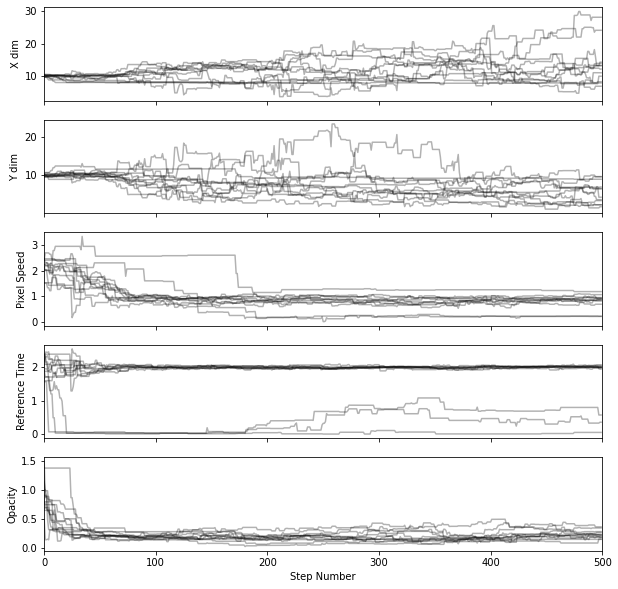

In [25]:
##This block plots the traces of the 4 parameters
fig, axes = plt.subplots(5,figsize = (10,10), sharex = True)
samples = sampler.get_chain()
labels = ["X dim", "Y dim", "Pixel Speed", "Reference Time", "Opacity"]
for i in range(ndim):
    axes[i].plot(samples[:,:,i],'k',alpha = 0.3)
    axes[i].set_xlim(0,len(samples))
    axes[i].set_ylabel(labels[i])
    
axes[-1].set_xlabel("Step Number")
plt.show()

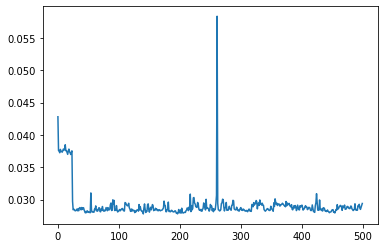